# `Research Question`: Can we predict a game’s Metascore or User score solely from review text?

# Task 1: Creating Corpus

## Extract Reviews From MetaCritic

In [ ]:
# Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/NLP_FINAL

/content/drive/MyDrive/NLP_FINAL


## Get Games List

In [ ]:
import requests
import re
import time

In [ ]:
base_url = "https://www.metacritic.com/game/"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36"
}
response = requests.get(base_url, headers=headers)
response

<Response [200]>

In [ ]:
html = response.text

In [ ]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(html, 'html.parser')

In [ ]:
#items = soup.find_all('div', {'data-testid': 'product-card'})
items = soup.find_all('div', attrs={'data-testid': re.compile(r'^product-card')})
len(items)

81

In [ ]:
games = []
for item in items:
  link_tag = item.find('a', href=True)
  if link_tag:
      href = link_tag['href']
      games.append(href)
#games

In [ ]:
games

['/game/winter-burrow/',
 '/game/million-depth/',
 '/game/possessors/',
 '/game/kingdom-come-deliverance-ii-mysteria-ecclesiae/',
 '/game/lumines-arise/',
 '/game/rue-valley/',
 '/game/sacred-2-remaster/',
 '/game/goodnight-universe/',
 '/game/hyrule-warriors-age-of-imprisonment/',
 '/game/syberia-remastered/',
 '/game/biped-2/',
 '/game/skald-against-the-black-priory/',
 '/game/europa-universalis-v/',
 '/game/football-manager-26/',
 '/game/devil-jam/',
 '/game/tales-of-xillia-remastered/',
 '/game/mortal-kombat-legacy-kollection/',
 '/game/dragon-quest-i-and-ii-hd-2d-remake/',
 '/game/arc-raiders/',
 '/game/virtua-fighter-5-revo-world-stage/',
 '/game/surviving-mars-relaunched/',
 '/game/lumines-arise/',
 '/game/anno-117-pax-romana/',
 '/game/call-of-duty-black-ops-7/',
 '/game/escape-from-tarkov/',
 '/game/kirby-air-riders/',
 '/game/metroid-prime-4-beyond/',
 '/game/octopath-traveler-0/',
 '/game/terminator-2d-no-fate/',
 '/game/the-legend-of-heroes-trails-beyond-the-horizon/',
 '/g

## Fetch Reviews From Each Game

In [ ]:
# unfortunately selenium appraoch does not work as expected.

In [ ]:
def continue_fetch_if_needed(items_info, game, metascore, avg_user_score):
  for page in range(10):
    time.sleep(0.2)
    game_name = game.replace('/game/', '').strip('/')
    url = f"https://backend.metacritic.com/reviews/metacritic/user/games/{game_name}/web?offset={page * 50}&limit=50"
    results = requests.get(url, headers=headers, timeout=30)
    data = results.json()['data']['items']
    for review in data:
      items_info.append(
        {
            'game': game,
            'avg_user_score': avg_user_score,
            'meta_score': meta_score,
            #'user_score': review['score'],
            'review': review['quote']
        }
      )

def get_reviews(items_info, game, metascore, avg_user_score):
  url = "https://www.metacritic.com" + game + 'user-reviews/'
  headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36"
  }
  response = requests.get(url, headers=headers)
  html = response.text
  soup = BeautifulSoup(html, 'html.parser')
  divs = soup.find_all('div', {'data-testid': 'product-review'})
  for d in divs:
      quote_div = d.find("div", class_=re.compile(r"\bc-siteReview_quote\b"))
      span = quote_div.find("span")

      user_score_div = d.find("div", class_=re.compile(r"\bc-siteReviewScore_background-user\b"))
      score = user_score_div.find("span")

      if span:
          items_info.append(
              {
                  'game': game,
                  'avg_user_score': avg_user_score,
                  'meta_score': meta_score,
                  'user_score': score.get_text(strip=True),
                  'review': span.get_text(strip=True).strip('"')
              }
            )
  if len(divs) >= 50:
    continue_fetch_if_needed(items_info, game, metascore, avg_user_score)

In [ ]:
items_info = []
for game in games:
  url = "https://www.metacritic.com" + game
  headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36"
  }
  response = requests.get(url, headers=headers) # Corrected: use 'url' instead of 'base_url'
  html = response.text
  soup = BeautifulSoup(html, 'html.parser')

  user_score = None
  user_div = soup.find('div', {'data-testid': 'user-score-info'})
  if user_div:
    #span = user_div.find('span')
    #so annoying
    span = user_div.find('span', attrs={'data-v-e408cafe': True})
    if span:
      user_score = span.get_text(strip=True)
      if user_score == 'tbd':
        continue
    else:
      continue

  meta_score = None
  meta_div = soup.find('div', {'data-testid': 'critic-score-info'})
  if meta_div:
    span = meta_div.find('span', attrs={'data-v-e408cafe': True})
    if span:
      meta_score = span.get_text(strip=True)
      if meta_score == 'tbd':
        continue
    else:
      continue

  get_reviews(items_info, game, meta_score, user_score)

  #items_info.append({
  #    'Game': game,
  #    'Userscore': user_score,
  #    'Metascore': meta_score
  #})
  time.sleep(1)

In [ ]:
len(items_info)

13536

In [ ]:
file_name = 'dataset/games_reviews_info.csv'
import pandas as pd
df = pd.DataFrame(items_info)
df.to_csv(file_name)

In [ ]:
df.head(20)

,game,avg_user_score,meta_score,user_score,review
0,/game/kingdom-come-deliverance-ii-mysteria-ecc...,7.4,81,10,Hasta el momento muy contento con Misteria Ecc...
1,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9,"I loved this game the whole way through, even ..."
2,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9,[SPOILER ALERT: This review contains spoilers.]
3,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9,Hyrule Warriors: Age of Imprisonment stands ou...
4,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10,"I normally do not enjoy these kind of games, b..."
5,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10,I have played Hyrule Warriors on the 3DS and n...
6,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,0,Minha crítica de Hyrule Warriors: Age of Impri...
7,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10,"Despite the average story, this is easily the ..."
8,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10,Perfect game good story keeps you hooked and w...
9,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10,The best in the series by far. Ignore the fact...


# Task 2: Text Preprocessing

In [ ]:
import pandas as pd

In [ ]:
# Loading the data set
df = pd.read_csv('/content/drive/MyDrive/NLP_FINAL/dataset/games_reviews_info.csv')

In [ ]:
# Show the first few rows
df.head()

,Unnamed: 0,game,avg_user_score,meta_score,user_score,review
0,0,/game/kingdom-come-deliverance-ii-mysteria-ecc...,7.4,81,10.0,Hasta el momento muy contento con Misteria Ecc...
1,1,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,"I loved this game the whole way through, even ..."
2,2,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,[SPOILER ALERT: This review contains spoilers.]
3,3,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,Hyrule Warriors: Age of Imprisonment stands ou...
4,4,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10.0,"I normally do not enjoy these kind of games, b..."


## Fuzz game name in review

In [ ]:
import re

def normalize_simple(text):
    text = str(text)
    text = text.replace(':', ' ')
    text = text.replace('-', ' ')
    text = re.sub(r'\s+', ' ', text)  # collapse multiple spaces
    return text.strip()

def extract_game_name(game_path):
    name = game_path.replace('/game/', '').strip('/')
    name = normalize_simple(name).lower()
    return name

def replace_game_name_in_review(row):
    review = normalize_simple(row['review'])
    game_name = row['game_name']  # already normalized and lowercased

    escaped_game_name = re.escape(game_name)
    pattern = re.compile(r'\b' + escaped_game_name + r'\b', re.IGNORECASE)

    cleaned = pattern.sub('the game', review)
    return cleaned


In [ ]:
df['game_name'] = df['game'].apply(extract_game_name)
df['review'] = df.apply(replace_game_name_in_review, axis=1)

In [ ]:
df.tail(10)

,Unnamed: 0,game,avg_user_score,meta_score,user_score,review,game_name
13526,13526,/game/keeper/,7.5,79,NaN,"The amazing art style, the lighthouse transfor...",keeper
13527,13527,/game/keeper/,7.5,79,NaN,"An original experience, pure art in movement. ...",keeper
13528,13528,/game/keeper/,7.5,79,NaN,where is the game? I can even feel a bit sorry...,keeper
13529,13529,/game/keeper/,7.5,79,NaN,Un vent de fraîcheur ... Change de tous les au...,keeper
13530,13530,/game/keeper/,7.5,79,NaN,XGP 虽然没有玩下去《脑航员》，但听闻Double Fine是个挺有创意的工作室，所以对本...,keeper
13531,13531,/game/keeper/,7.5,79,NaN,Beautiful world great story on gamepass u can ...,keeper
13532,13532,/game/keeper/,7.5,79,NaN,Ten out of ten. Reminds me some much the vibes...,keeper
13533,13533,/game/keeper/,7.5,79,NaN,"the game é uma experiência sensacional, um jog...",keeper
13534,13534,/game/keeper/,7.5,79,NaN,Beautiful & tonnes of Double Fine charm I abso...,keeper
13535,13535,/game/keeper/,7.5,79,NaN,the game is an overall brilliant puzzle advent...,keeper


## Language Inspection

In [ ]:
# Install library
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 26.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=a8165ae2286c554594b5e9c7a652e142fbfc9386367e1711906d861477d6a4f6
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13536 entries, 0 to 13535
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      13536 non-null  int64  
 1   game            13536 non-null  object 
 2   avg_user_score  13536 non-null  float64
 3   meta_score      13536 non-null  int64  
 4   user_score      1958 non-null   float64
 5   review          13530 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 634.6+ KB


In [ ]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0  # reproducibility

def detect_language(text):
    try:
        if isinstance(text, str) and len(text.strip()) > 5:
            return detect(text)
        else:
            return "unknown"
    except:
        return "error"

In [ ]:
# Apply language detection
df['lang'] = df['review'].apply(detect_language)

In [ ]:
# Check Language Distribution
df['lang'].value_counts()

,count
lang,
en,10488
es,901
pt,711
fr,460
ru,189
it,184
tr,143
de,124
zh-cn,43


In [ ]:
# % in Language Distribution
df['lang'].value_counts(normalize=True) * 100

,proportion
lang,
en,77.482270
es,6.656324
pt,5.252660
fr,3.398345
ru,1.396277
it,1.359338
tr,1.056442
de,0.916076
zh-cn,0.317671


In [ ]:
# Non-English Samples
non_english_df = df[df['lang'] != 'en']
non_english_df[['review']].head(30)

,review
0,Hasta el momento muy contento con Misteria Ecc...
6,Minha crítica de Hyrule Warriors: Age of Impri...
10,전작인 젤다무쌍 대재앙의 시대와 비교하면 그래픽도 좋고 60프레임에 호쾌한 액션도 ...
20,Hyrule Warriors é a fusão perfeita entre Zelda...
33,Un Banger qui scelle enfin le destin d’HyruleA...
34,Performance : le jeu est fluide et tient les 6...
36,Syberia Remastered redonne vie au classique cu...
40,"Jogo chegou incrível, levando um prazer de jog..."
56,新的UI导致了巨大的问题，老玩家开始不知所措，而且有严重的各种bug，再补充一点，不知道费劲...
89,Nach 49 Stunden und dem fehlen eines richtigen...


## Remove Non-English

In [ ]:
# English Language row
df_en = df[df['lang'] == 'en'].copy()
df_en.shape

(10488, 7)

In [ ]:
df_en.head()

,game,avg_user_score,meta_score,user_score,review,lang,word_count
1,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,"I loved this game the whole way through, even ...",en,130
2,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,[SPOILER ALERT: This review contains spoilers.],en,6
3,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,Hyrule Warriors: Age of Imprisonment stands ou...,en,339
4,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10.0,"I normally do not enjoy these kind of games, b...",en,70
5,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10.0,I have played Hyrule Warriors on the 3DS and n...,en,337


## Basic Corpus Statistics

In [ ]:
df_en = df_en.loc[:, ~df_en.columns.str.contains('^Unnamed')]

# Document length
df_en['word_count'] = df_en['review'].apply(lambda x: len(str(x).split()))

total_docs = df_en.shape[0]
avg_length = df_en['word_count'].mean()
max_length = df_en['word_count'].max()
unique_games = df_en['game'].nunique()

In [ ]:
df_en.columns

Index(['game', 'avg_user_score', 'meta_score', 'user_score', 'review', 'lang',
       'word_count'],
      dtype='object')

In [ ]:
total_docs, avg_length, max_length, unique_games

(10488, np.float64(79.14721586575133), 927, 46)

In [ ]:
# Save english to csv file to snapshot
file_name = 'dataset/games_reviews_ENGLISH.csv'
df_en.to_csv(file_name)

In [ ]:
import pandas as pd
df_en = pd.read_csv(file_name)
df_en.head()

,Unnamed: 0,game,avg_user_score,meta_score,user_score,review,lang,word_count
0,1,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,"I loved this game the whole way through, even ...",en,130
1,2,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,[SPOILER ALERT: This review contains spoilers.],en,6
2,3,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,Hyrule Warriors: Age of Imprisonment stands ou...,en,339
3,4,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10.0,"I normally do not enjoy these kind of games, b...",en,70
4,5,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10.0,I have played Hyrule Warriors on the 3DS and n...,en,337


In [ ]:
import pandas as pd
df_en = pd.read_csv('/content/drive/MyDrive/NLP_FINAL/dataset/games_reviews_ENGLISH.csv')
df_en.head()

,Unnamed: 0,game,avg_user_score,meta_score,user_score,review,lang,word_count
0,1,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,"I loved this game the whole way through, even ...",en,130
1,2,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,[SPOILER ALERT: This review contains spoilers.],en,6
2,3,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,Hyrule Warriors: Age of Imprisonment stands ou...,en,339
3,4,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10.0,"I normally do not enjoy these kind of games, b...",en,70
4,5,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10.0,I have played Hyrule Warriors on the 3DS and n...,en,337


## Importing Required Libraries

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np

import spacy
import nltk
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import WordNetLemmatizer

In [ ]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
# Basic setup and quick inspection
import pandas as pd
import numpy as np

# Reset index (optional but cleaner)
df_en = df_en.reset_index(drop=True)

# Ensure 'review' has no NaN (replace with empty string)
df_en['review'] = df_en['review'].fillna("")

# Quick shape and sample
print("Shape:", df_en.shape)
df_en[['game', 'review']].head(3)

Shape: (10488, 8)


,game,review
0,/game/hyrule-warriors-age-of-imprisonment/,"I loved this game the whole way through, even ..."
1,/game/hyrule-warriors-age-of-imprisonment/,[SPOILER ALERT: This review contains spoilers.]
2,/game/hyrule-warriors-age-of-imprisonment/,Hyrule Warriors: Age of Imprisonment stands ou...


## Contraction Expansion

Game reviews often contain informal writing, including contractions such as don’t, can’t, I’m, or it’s.
These forms increase vocabulary sparsity and may interfere with accurate lemmatization.
To reduce this linguistic variability, we applied contraction expansion using the contractions Python package.

This transforms words like:

“can’t” → “cannot”

“I’m” → “I am”

“don’t” → “do not”

Expanding contractions helps standardize language, improve token recognition, and support better downstream processing.

In [ ]:
# Contraction Expansion
!pip install contractions
import contractions

def contraction_expansion(text):
    expanded = []
    for word in text.split():
        expanded.append(contractions.fix(word))
    return ' '.join(expanded)

df_en['review_expanded'] = df_en['review'].apply(contraction_expansion)

# Output check
df_en[['review', 'review_expanded']].head()

,review,review_expanded
0,"I loved this game the whole way through, even ...","I loved this game the whole way through, even ..."
1,[SPOILER ALERT: This review contains spoilers.],[SPOILER ALERT: This review contains spoilers.]
2,Hyrule Warriors: Age of Imprisonment stands ou...,Hyrule Warriors: Age of Imprisonment stands ou...
3,"I normally do not enjoy these kind of games, b...","I normally do not enjoy these kind of games, b..."
4,I have played Hyrule Warriors on the 3DS and n...,I have played Hyrule Warriors on the 3DS and n...


## Tokenization

We used SpaCy’s English language pipeline (en_core_web_sm) to perform tokenization.
This tokenizer is well-suited for user-generated game reviews because it:

Accurately segments text into tokens, even when punctuation or irregular spacing is present

Handles informal language such as slang, abbreviations, and conversational patterns

Separates punctuation, emojis, and symbols effectively

Maintains consistent rules for contractions, hyphenated words, and special characters

Provides built-in support for POS tagging and dependency parsing, which ensures consistency in our downstream steps such as lemmatization and filtering

Using a modern NLP toolkit like spaCy ensures that our tokenization aligns with real-world text structure and supports reliable preprocessing for all later tasks.

In [ ]:
# Tokenization using SpaCy
# Import and download Spacy en_core
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Tokenization expanded text
df_en['review_tokens'] = df_en['review_expanded'].apply(
    lambda x: [token.text for token in nlp(x)]
)

df_en['review_tokens'].head(3)

,review_tokens
0,"[I, loved, this, game, the, whole, way, throug..."
1,"[[, SPOILER, ALERT, :, This, review, contains,..."
2,"[Hyrule, Warriors, :, Age, of, Imprisonment, s..."


# Preprocessing Cleaning Tokens (Lowercase, URLs, HTML, punctuation, digits, stopwords, short words)

Before deeper linguistic processing, we performed several normalization steps to clean raw text.
This included:

Lowercasing all text to reduce case-based duplication (e.g., Game vs. game)

Removing URLs, which commonly appear in user reviews (“check this link…”)

Removing HTML tags or markup, which may appear in scraped text

Filtering out digits and alphanumeric noise

Removing punctuation and special characters, leaving alphabetic tokens only

Removing stopwords, which typically do not contribute meaningful semantic information

Discarding overly short tokens (length < 3) that are unlikely to provide analytical value

These steps produce a cleaner and more semantically meaningful token set for modeling.

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

def clean_tokens(tokens):
    """
    Standardized preprocessing pipeline:
    - lowercase
    - remove URLs & HTML
    - keep only alphabetic characters
    - remove digits
    - remove stopwords
    - remove short tokens (<3)
    """
    cleaned = []
    for token in tokens:

        token = token.lower()

        # Remove URLs
        token = re.sub(r"http\S+|www\S+|https\S+", "", token)

        # Remove HTML tags
        token = re.sub(r"<.*?>", "", token)

        # Keep only letters
        token = re.sub(r"[^a-zA-Z]", "", token)

        # Skip empty & short tokens
        if len(token) < 3:
            continue

        # Skip digits
        if any(char.isdigit() for char in token):
            continue

        # Skip stopwords
        if token in stop_words:
            continue

        cleaned.append(token)

    return cleaned

df_en["clean_tokens"] = df_en["review_tokens"].apply(clean_tokens)
df_en[["review_tokens", "clean_tokens"]].head(3)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review_tokens,clean_tokens
0,"[I, loved, this, game, the, whole, way, throug...","[loved, game, whole, way, even, someone, despi..."
1,"[[, SPOILER, ALERT, :, This, review, contains,...","[spoiler, alert, review, contains, spoilers]"
2,"[Hyrule, Warriors, :, Age, of, Imprisonment, s...","[hyrule, warriors, age, imprisonment, stands, ..."


## Part-of-Speech (POS) Tagging (spaCy)

To enable linguistically informed preprocessing, we applied POS tagging using spaCy’s integrated tagger.
POS tagging identifies the grammatical category of each token (e.g., NOUN, VERB, ADJ, ADV), which is crucial for:

Accurate lemmatization

Selecting content-rich words for topic modeling

Structuring features for supervised learning

Understanding syntactic patterns in user feedback

Using spaCy for both tokenization and POS tagging ensures consistency and minimizes cross-tool mismatch.

In [ ]:
# POS Tagging using SpaCy
def spacy_pos(tokens):
    doc = nlp(" ".join(tokens))
    return [(token.text, token.pos_) for token in doc]

%time df_en['pos_tags'] = df_en['clean_tokens'].apply(spacy_pos)

# Output check: see tokens and POS tags for first 2 rows
df_en[['clean_tokens', 'pos_tags']].head(3)

CPU times: user 2min 21s, sys: 252 ms, total: 2min 21s
Wall time: 2min 25s


,clean_tokens,pos_tags
0,"[loved, game, whole, way, even, someone, despi...","[(loved, VERB), (game, NOUN), (whole, ADJ), (w..."
1,"[spoiler, alert, review, contains, spoilers]","[(spoiler, PROPN), (alert, NOUN), (review, NOU..."
2,"[hyrule, warriors, age, imprisonment, stands, ...","[(hyrule, NOUN), (warriors, NOUN), (age, NOUN)..."


## Lemmatization (spaCy)

We applied spaCy’s built-in lemmatizer to convert each token to its canonical base form:

“running” → “run”

“games” → “game”

“better” → “good”

“reviews” → “review”

Lemmatization reduces vocabulary size and improves generalization for models such as TF-IDF, LDA, and machine-learning classifiers.
By pairing lemmatization with POS tags, the correct lemma can be selected based on word role.

In [ ]:
# Lemmatization (spaCy)
# Use spaCy lemmas with POS info; filter out stopwords & punctuation again.

def lemmatize_spacy(tokens):
    doc = nlp(" ".join(tokens))
    lemmas = []
    for token in doc:
        # skip punctuation and spaces
        if token.is_punct or token.is_space:
            continue
        # skip stopwords
        if token.is_stop:
            continue
        lemmas.append(token.lemma_)
    return lemmas

%time df_en['lemmas'] = df_en['clean_tokens'].apply(lemmatize_spacy)

# Output check: see clean_tokens vs lemmas
df_en[['clean_tokens', 'lemmas']].head(3)

CPU times: user 2min 22s, sys: 147 ms, total: 2min 22s
Wall time: 2min 24s


,clean_tokens,lemmas
0,"[loved, game, whole, way, even, someone, despi...","[love, game, way, despise, age, calamity, game..."
1,"[spoiler, alert, review, contains, spoilers]","[spoiler, alert, review, contain, spoiler]"
2,"[hyrule, warriors, age, imprisonment, stands, ...","[hyrule, warrior, age, imprisonment, stand, op..."


In [ ]:
df_en.head()

,Unnamed: 0,game,avg_user_score,meta_score,user_score,review,lang,word_count,review_expanded,review_tokens,clean_tokens,pos_tags,lemmas
0,1,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,"I loved this game the whole way through, even ...",en,130,"I loved this game the whole way through, even ...","[I, loved, this, game, the, whole, way, throug...","[loved, game, whole, way, even, someone, despi...","[(loved, VERB), (game, NOUN), (whole, ADJ), (w...","[love, game, way, despise, age, calamity, game..."
1,2,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,[SPOILER ALERT: This review contains spoilers.],en,6,[SPOILER ALERT: This review contains spoilers.],"[[, SPOILER, ALERT, :, This, review, contains,...","[spoiler, alert, review, contains, spoilers]","[(spoiler, PROPN), (alert, NOUN), (review, NOU...","[spoiler, alert, review, contain, spoiler]"
2,3,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,Hyrule Warriors: Age of Imprisonment stands ou...,en,339,Hyrule Warriors: Age of Imprisonment stands ou...,"[Hyrule, Warriors, :, Age, of, Imprisonment, s...","[hyrule, warriors, age, imprisonment, stands, ...","[(hyrule, NOUN), (warriors, NOUN), (age, NOUN)...","[hyrule, warrior, age, imprisonment, stand, op..."
3,4,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10.0,"I normally do not enjoy these kind of games, b...",en,70,"I normally do not enjoy these kind of games, b...","[I, normally, do, not, enjoy, these, kind, of,...","[normally, enjoy, kind, games, one, really, su...","[(normally, ADV), (enjoy, VERB), (kind, ADJ), ...","[normally, enjoy, kind, game, surprise, work, ..."
4,5,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10.0,I have played Hyrule Warriors on the 3DS and n...,en,337,I have played Hyrule Warriors on the 3DS and n...,"[I, have, played, Hyrule, Warriors, on, the, 3...","[played, hyrule, warriors, never, made, far, l...","[(played, VERB), (hyrule, NOUN), (warriors, NO...","[play, hyrule, warrior, far, like, zelda, huge..."


In [ ]:
#Do Snapshot!
save_path = "/content/drive/MyDrive/NLP_FINAL/dataset/games_reviews_lemmas_final.csv"

df_en.to_csv(save_path, index=False)
print("Saved to:", save_path)

Saved to: /content/drive/MyDrive/NLP_FINAL/dataset/games_reviews_lemmas_final.csv


In [ ]:
# Join lemmas into final clean_text column

df_en['clean_text'] = df_en['lemmas'].apply(lambda x: " ".join(x))

# Output check: show original review vs clean_text
df_en[['review', 'clean_text']].head(5)

,review,clean_text
0,"I loved this game the whole way through, even ...",love game way despise age calamity game phenom...
1,[SPOILER ALERT: This review contains spoilers.],spoiler alert review contain spoiler
2,Hyrule Warriors: Age of Imprisonment stands ou...,hyrule warrior age imprisonment stand opinion ...
3,"I normally do not enjoy these kind of games, b...",normally enjoy kind game surprise work perfect...
4,I have played Hyrule Warriors on the 3DS and n...,play hyrule warrior far like zelda huge zelda ...


In [ ]:
# Preprocessing summary stats

# Original length (in tokens)
df_en['len_tokens'] = df_en['review_tokens'].apply(len)

# Cleaned length (in tokens)
df_en['len_clean_tokens'] = df_en['clean_tokens'].apply(len)

print("Average tokens BEFORE cleaning:", df_en['len_tokens'].mean())
print("Average tokens AFTER cleaning:", df_en['len_clean_tokens'].mean())

print("Max tokens BEFORE cleaning:", df_en['len_tokens'].max())
print("Max tokens AFTER cleaning:", df_en['len_clean_tokens'].max())

Average tokens BEFORE cleaning: 91.79128527841343
Average tokens AFTER cleaning: 40.591914569031275
Max tokens BEFORE cleaning: 1085
Max tokens AFTER cleaning: 472


## Statistics & Lexical Diversity

In [ ]:
def calculate_lexical_diversity(tokens):
    if not tokens:
        return 0
    return len(set(tokens)) / len(tokens)

df_en['lexical_diversity'] = df_en['lemmas'].apply(calculate_lexical_diversity)

avg_lexical_diversity = df_en['lexical_diversity'].mean()

print(f"Average Lexical Diversity: {avg_lexical_diversity:.4f}")

Average Lexical Diversity: 0.8916


In [ ]:
all_tokens = []
for tokens_list in df_en['lemmas']:
    all_tokens.extend(tokens_list)

total_unique_tokens = len(set(all_tokens))
print(f"Total Unique Tokens: {total_unique_tokens}")

Total Unique Tokens: 14787


In [ ]:
df_en['processed_token_count'] = df_en['lemmas'].apply(len)
avg_processed_token_count = df_en['processed_token_count'].mean()
print(f"Average Processed Token Count: {avg_processed_token_count:.2f}")

Average Processed Token Count: 35.25


# Task 3: Data Understanding and Preparation

In [ ]:
# Data Understanding
# user_score and meta_score
# Import the required libraries

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
# Quick sanity info
print(df_en[['user_score', 'meta_score']].describe())

        user_score    meta_score
count  1544.000000  10488.000000
mean      7.446891     89.816743
std       3.203777      5.719116
min       0.000000     70.000000
25%       6.000000     86.000000
50%       9.000000     92.000000
75%      10.000000     94.000000
max      10.000000     96.000000


## Inspect User Score

### Distribution

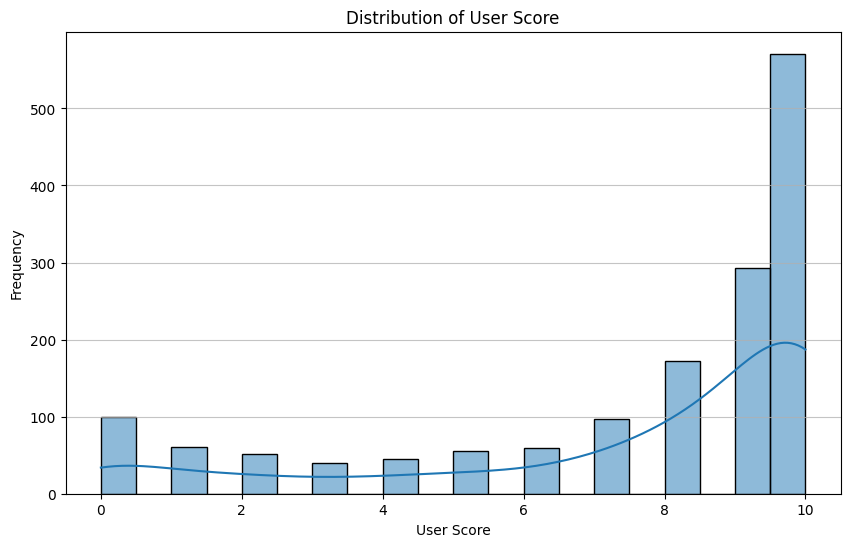

In [ ]:
# User Score Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_en['user_score'], bins=20, kde=True)
plt.title('Distribution of User Score')
plt.xlabel('User Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

### Data Sanity Check

In [ ]:
# Missing values check
empty_user_score_rows_count = df_en['user_score'].isnull().sum()
print(f"Number of rows with empty user_score: {empty_user_score_rows_count}")

Number of rows with empty user_score: 8944


### Normalization

In [ ]:
# Normalize user_score from 0-10 to -1 to 1
# Existing user_score range is typically 0-10.

##### NORMALIZE IT TO -1 ~ 1

# new_score = -1 + user_score / 5

df_en['normalized_user_score'] = df_en['user_score'].apply(lambda x: (x / 5) - 1 if pd.notna(x) else x)
print("Original User Score Description:")
print(df_en['user_score'].describe())
print("\nNormalized User Score Description:")
print(df_en['normalized_user_score'].describe())

print("\nFirst 5 rows with original and normalized user scores:")
print(df_en[['user_score', 'normalized_user_score']].head())

Original User Score Description:
count    1544.000000
mean        7.446891
std         3.203777
min         0.000000
25%         6.000000
50%         9.000000
75%        10.000000
max        10.000000
Name: user_score, dtype: float64

Normalized User Score Description:
count    1544.000000
mean        0.489378
std         0.640755
min        -1.000000
25%         0.200000
50%         0.800000
75%         1.000000
max         1.000000
Name: normalized_user_score, dtype: float64

First 5 rows with original and normalized user scores:
   user_score  normalized_user_score
0         9.0                    0.8
1         9.0                    0.8
2         9.0                    0.8
3        10.0                    1.0
4        10.0                    1.0


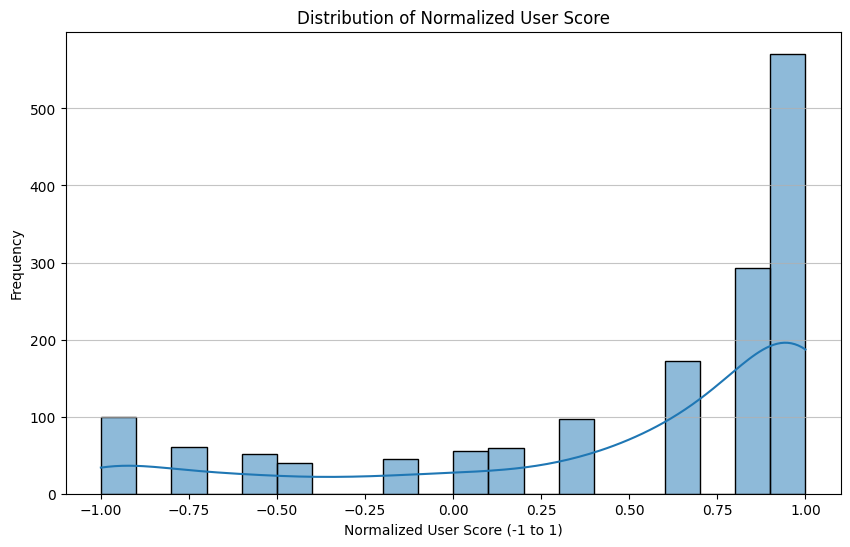

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_en['normalized_user_score'], bins=20, kde=True)
plt.title('Distribution of Normalized User Score')
plt.xlabel('Normalized User Score (-1 to 1)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Inspect Meta Score

### Distribution

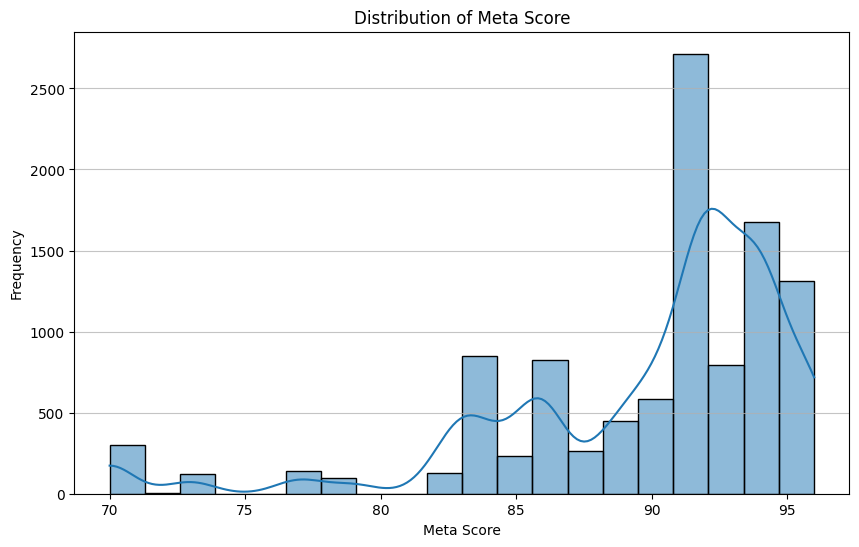

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_en['meta_score'], bins=20, kde=True)
plt.title('Distribution of Meta Score')
plt.xlabel('Meta Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

### Data Sanity Check

In [ ]:
empty_meta_score_rows_count = df_en['meta_score'].isnull().sum()
print(f"Number of rows with empty meta_score: {empty_meta_score_rows_count}")

Number of rows with empty meta_score: 0


### Normalization

In [ ]:
# new_score = -1 + meta_score / 50

df_en['normalized_meta_score'] = df_en['meta_score'].apply(lambda x: (x / 50) - 1 if pd.notna(x) else x)

print("Original Meta Score Description:")
print(df_en['meta_score'].describe())
print("\nNormalized Meta Score Description:")
print(df_en['normalized_meta_score'].describe())

# Display some of the normalized scores
print("\nFirst 5 rows with original and normalized meta scores:")
print(df_en[['meta_score', 'normalized_meta_score']].head())

Original Meta Score Description:
count    10488.000000
mean        89.816743
std          5.719116
min         70.000000
25%         86.000000
50%         92.000000
75%         94.000000
max         96.000000
Name: meta_score, dtype: float64

Normalized Meta Score Description:
count    10488.000000
mean         0.796335
std          0.114382
min          0.400000
25%          0.720000
50%          0.840000
75%          0.880000
max          0.920000
Name: normalized_meta_score, dtype: float64

First 5 rows with original and normalized meta scores:
   meta_score  normalized_meta_score
0          79                   0.58
1          79                   0.58
2          79                   0.58
3          79                   0.58
4          79                   0.58


In [ ]:
df_en[['meta_score', 'normalized_meta_score']].head()

,meta_score,normalized_meta_score
0,79,0.58
1,79,0.58
2,79,0.58
3,79,0.58
4,79,0.58


In [ ]:
df_en.columns

Index(['Unnamed: 0', 'game', 'avg_user_score', 'meta_score', 'user_score',
       'review', 'lang', 'word_count', 'normalized_user_score',
       'normalized_meta_score'],
      dtype='object')

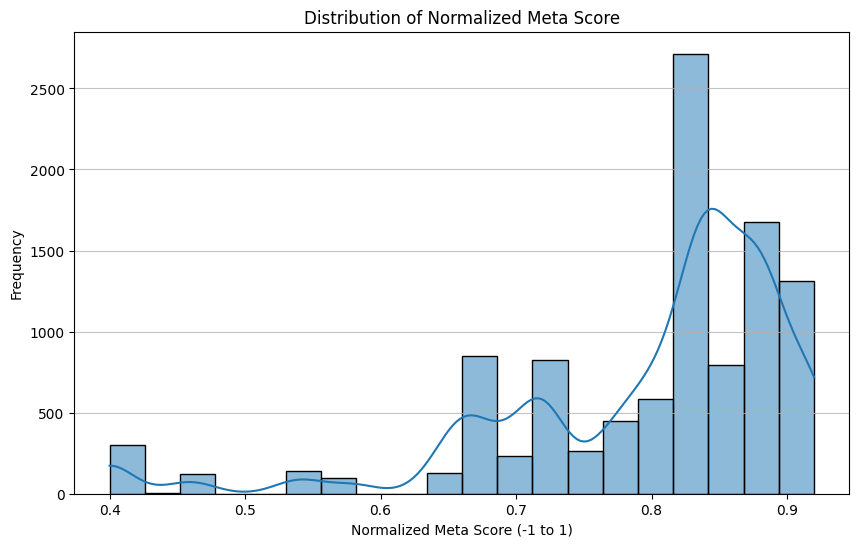

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_en['normalized_meta_score'], bins=20, kde=True)
plt.title('Distribution of Normalized Meta Score')
plt.xlabel('Normalized Meta Score (-1 to 1)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Correlation between user_score and meta_score

In [ ]:
print("\nCorrelation between user_score and meta_score:")
print(df_en[['user_score', 'meta_score']].corr())


Correlation between user_score and meta_score:
            user_score  meta_score
user_score    1.000000    0.339488
meta_score    0.339488    1.000000


In [ ]:
#HWT

## Feature Engineering

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 26.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import gensim.downloader as api

# https://radimrehurek.com/gensim/models/word2vec.html
# i guess its glove-twitter-100??
glove_model = api.load("glove-twitter-100")
glove_model.vector_size

[==================================================] 100.0% 387.1/387.1MB downloaded


100

In [ ]:
!pip install gensim

import gensim.downloader as api
import numpy as np
import pandas as pd
import pandas as pd

def document_vector(tokens, model):
    """
    Converts list of tokens into a document vector using average word embeddings.
    Returns zero vector if no token appears in model vocabulary.
    """
    valid_tokens = [t for t in tokens if t in model.key_to_index]
    if not valid_tokens:
        return np.zeros(model.vector_size, dtype=np.float32)
    vectors = [model[t] for t in valid_tokens]
    return np.mean(vectors, axis=0)

### Glove Twitter-100

In [ ]:
def document_vector(tokens, model):
    # okay no need to exclude misspell... if not on the list, automatically exclude!
    valid_tokens = [token for token in tokens if token in model.key_to_index]
    if not valid_tokens:
        return np.zeros(model.vector_size)
    vectors = [model[token] for token in valid_tokens]
    return np.mean(vectors, axis=0)

%time glove_vector = df_en['review_lemmas_final'].apply(lambda tokens: document_vector(tokens, glove_model))

CPU times: user 1 s, sys: 7.97 ms, total: 1.01 s
Wall time: 1.04 s


In [ ]:
glove_vectors_list = glove_vector.tolist()
glove_df = pd.DataFrame(glove_vectors_list)
glove_df.shape

(10488, 100)

In [ ]:
glove_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.065763,0.060864,0.143175,0.023299,-0.043840,0.208756,0.313871,-0.069687,0.004508,0.065826,...,-0.066407,0.151751,-0.092752,-0.203692,0.052518,0.024474,0.095669,0.043168,0.011627,0.075267
1,0.125118,0.245152,-0.257396,-0.337886,0.106837,-0.533014,0.528140,-0.498586,0.099581,0.160891,...,-0.335908,0.208859,-0.022818,-0.302128,0.257812,0.040836,0.093712,0.048749,0.047263,0.192510
2,0.114674,-0.012576,0.055752,-0.036793,0.051947,0.231803,0.195838,-0.085615,-0.077060,0.005912,...,-0.044753,0.229563,-0.021114,-0.149984,0.142050,0.016031,0.146970,0.045305,0.012451,-0.058647
3,0.187268,0.182997,0.022452,-0.114677,-0.057095,0.254930,0.302741,-0.231800,0.064185,0.143210,...,-0.176099,0.293914,-0.130702,-0.144497,0.142432,-0.110598,0.091160,0.068767,-0.005286,-0.191866
4,0.117014,0.112587,0.021228,-0.065787,-0.014543,0.259303,0.240779,-0.115540,-0.025595,0.056499,...,-0.116367,0.204252,-0.114316,-0.208687,0.133609,-0.054847,0.078636,-0.002935,0.056445,-0.019860


In [ ]:
glove_df['normalized_meta_score'] = df_en['normalized_meta_score'].values
glove_df['normalized_user_score'] = df_en['normalized_user_score'].values

glove_df.head()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,normalized_meta_score,normalized_user_score
0,0.065763,0.060864,0.143175,0.023299,-0.043840,0.208756,0.313871,-0.069687,0.004508,0.065826,...,-0.092752,-0.203692,0.052518,0.024474,0.095669,0.043168,0.011627,0.075267,0.58,0.8
1,0.125118,0.245152,-0.257396,-0.337886,0.106837,-0.533014,0.528140,-0.498586,0.099581,0.160891,...,-0.022818,-0.302128,0.257812,0.040836,0.093712,0.048749,0.047263,0.192510,0.58,0.8
2,0.114674,-0.012576,0.055752,-0.036793,0.051947,0.231803,0.195838,-0.085615,-0.077060,0.005912,...,-0.021114,-0.149984,0.142050,0.016031,0.146970,0.045305,0.012451,-0.058647,0.58,0.8
3,0.187268,0.182997,0.022452,-0.114677,-0.057095,0.254930,0.302741,-0.231800,0.064185,0.143210,...,-0.130702,-0.144497,0.142432,-0.110598,0.091160,0.068767,-0.005286,-0.191866,0.58,1.0
4,0.117014,0.112587,0.021228,-0.065787,-0.014543,0.259303,0.240779,-0.115540,-0.025595,0.056499,...,-0.114316,-0.208687,0.133609,-0.054847,0.078636,-0.002935,0.056445,-0.019860,0.58,1.0


In [ ]:
# snapshot
file_name = 'dataset/glove_vectors.csv'
glove_df.to_csv(file_name, index=False)

## GloVe (GloVe-Wiki-Gigaword-50)

In [ ]:
# GloVe (glove-wiki-gigaword-50)
glove_model = api.load("glove-wiki-gigaword-50")
print("GloVe dim:", glove_model.vector_size)

%time glove_vec_series = df_en['lemmas'].apply(lambda toks: document_vector(toks, glove_model))
glove_vectors = np.stack(glove_vec_series.values)
glove_df = pd.DataFrame(glove_vectors)
glove_df['normalized_meta_score'] = df_en['normalized_meta_score'].values
glove_df['normalized_user_score'] = df_en['normalized_user_score'].values
display(glove_df.head())

[==================================================] 100.0% 66.0/66.0MB downloaded
GloVe dim: 50
CPU times: user 949 ms, sys: 5.04 ms, total: 954 ms
Wall time: 957 ms


,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,normalized_meta_score,normalized_user_score
0,-0.017650,0.327503,-0.288138,0.178819,0.341182,0.086402,-0.342318,0.000953,-0.339633,0.302168,...,-0.235154,0.211931,-0.168031,0.229196,0.211951,-0.237491,-0.077992,0.153297,0.58,0.8
1,0.269453,0.023564,0.464728,-0.239462,-0.403933,0.060602,0.522346,-0.209542,0.463482,-0.226434,...,-0.070834,-0.088804,0.009118,0.281344,0.308635,0.415134,0.298133,0.158988,0.58,0.8
2,0.116562,0.155079,-0.200301,-0.025586,0.263881,0.149506,-0.010542,-0.043681,-0.116242,0.270525,...,-0.140404,0.165911,-0.091155,0.050696,0.251701,-0.007495,-0.078880,0.183521,0.58,0.8
3,0.144403,0.128861,-0.153245,0.036706,0.351367,-0.007127,-0.338100,-0.052930,-0.100089,0.310292,...,-0.065188,0.307906,-0.019665,0.099745,0.266819,0.190412,0.025542,0.374955,0.58,1.0
4,-0.006996,0.144040,-0.046837,0.093780,0.226232,0.014154,-0.293878,-0.084246,-0.191803,0.263001,...,-0.104350,0.225986,-0.098611,0.197071,0.283306,-0.043100,-0.001585,0.204345,0.58,1.0


## Word2Vec (GoogleNews-300)

In [ ]:
w2v_model = api.load("word2vec-google-news-300")
print("Word2Vec dim:", w2v_model.vector_size)

%time w2v_vec_series = df_en['lemmas'].apply(lambda toks: document_vector(toks, w2v_model))
w2v_vectors = np.stack(w2v_vec_series.values)
w2v_df = pd.DataFrame(w2v_vectors)
w2v_df['normalized_meta_score'] = df_en['normalized_meta_score'].values
w2v_df['normalized_user_score'] = df_en['normalized_user_score'].values
display(w2v_df.head())

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2Vec dim: 300
CPU times: user 1.68 s, sys: 12.1 ms, total: 1.69 s
Wall time: 1.76 s


,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,normalized_meta_score,normalized_user_score
0,0.111210,0.047688,-0.003629,0.088442,0.011473,0.023103,0.112080,-0.105780,0.054549,0.093847,...,-0.111505,-0.054471,-0.032409,-0.048724,-0.004918,-0.078580,-0.036023,0.012102,0.58,0.8
1,0.020581,-0.025488,0.028076,-0.085498,-0.042352,0.020911,0.031525,0.033203,0.063867,0.055176,...,-0.082617,-0.013074,0.138892,-0.060930,-0.036743,-0.145605,-0.044434,-0.165527,0.58,0.8
2,0.064168,0.031464,-0.017669,0.054848,-0.028950,0.052354,0.088100,-0.041443,0.087139,0.080131,...,-0.081016,-0.025194,-0.065359,-0.033789,0.023112,-0.069649,-0.017190,-0.007387,0.58,0.8
3,0.021819,-0.014282,-0.089703,0.117922,-0.012614,0.029187,0.118192,-0.043124,0.048264,0.072235,...,-0.066622,0.022878,-0.044630,-0.025327,0.030758,-0.084682,0.015694,-0.021048,0.58,1.0
4,0.066727,0.056280,0.006623,0.103179,-0.014734,0.019493,0.088069,-0.085631,0.077504,0.089927,...,-0.086584,-0.022798,-0.046634,-0.028132,0.001604,-0.073991,-0.005279,-0.012281,0.58,1.0


## FastText (wiki-news-subwords-300)

In [ ]:
ft_model = api.load("fasttext-wiki-news-subwords-300")
print("FastText dim:", ft_model.vector_size)

%time ft_vec_series = df_en['lemmas'].apply(lambda toks: document_vector(toks, ft_model))
ft_vectors = np.stack(ft_vec_series.values)
ft_df = pd.DataFrame(ft_vectors)
ft_df['normalized_meta_score'] = df_en['normalized_meta_score'].values
ft_df['normalized_user_score'] = df_en['normalized_user_score'].values
display(ft_df.head())

[==================================================] 100.0% 958.5/958.4MB downloaded
FastText dim: 300
CPU times: user 945 ms, sys: 4.87 ms, total: 950 ms
Wall time: 952 ms


,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,normalized_meta_score,normalized_user_score
0,-0.002879,-0.033031,0.007749,0.033483,-0.020847,-0.015623,-0.019773,-0.106775,0.013375,0.015212,...,-0.010670,-0.025295,0.030303,-0.017031,0.020178,0.010330,0.016402,0.007877,0.58,0.8
1,-0.018612,-0.061280,-0.031346,0.047051,-0.030000,-0.004357,-0.021541,-0.102432,-0.035625,0.021480,...,0.026464,0.020507,0.005393,-0.029301,-0.006887,0.035402,0.005956,-0.027462,0.58,0.8
2,-0.010054,-0.017872,0.014754,0.026949,-0.027000,-0.017733,-0.015258,-0.105779,0.007774,0.009190,...,-0.013546,-0.007852,0.018606,-0.007017,0.007321,0.009447,-0.000017,-0.010633,0.58,0.8
3,0.000077,-0.001155,0.020250,0.013954,-0.028370,-0.014658,-0.005850,-0.114645,-0.017888,0.005975,...,-0.002689,-0.025843,0.026855,-0.012002,0.009128,0.003666,0.003867,-0.012370,0.58,1.0
4,-0.003787,-0.022734,0.005047,0.023862,-0.018310,-0.020433,-0.010800,-0.104027,0.004801,0.008535,...,-0.018756,-0.011704,0.029689,-0.015898,0.008875,-0.004979,0.020283,-0.000810,0.58,1.0


## Embedding Coverage Summary (Coverage, Dimensionality)

In [ ]:
def coverage_rate(vec_matrix):
    norms = np.linalg.norm(vec_matrix, axis=1)
    return np.mean(norms > 0)

summary_rows = []

for name, mat in [
    ("GloVe-50", glove_vectors),
    ("Word2Vec-300", w2v_vectors),
    ("FastText-300", ft_vectors),
]:
    summary_rows.append({
        "Embedding": name,
        "Dimensionality": mat.shape[1],
        "Doc Count": mat.shape[0],
        "Coverage (non-zero %)": 100 * coverage_rate(mat)
    })

emb_summary = pd.DataFrame(summary_rows)
emb_summary

,Embedding,Dimensionality,Doc Count,Coverage (non-zero %)
0,GloVe-50,50,10488,99.942792
1,Word2Vec-300,300,10488,99.942792
2,FastText-300,300,10488,99.942792


## Embedding Visualizations: PCA & t-SNE
### Create score bins based on meta_score

In [ ]:
def bin_score(x):
    if pd.isna(x):
        return "missing"
    if x <= -0.2:
        return "low"
    elif x <= 0.2:
        return "medium"
    else:
        return "high"

df_en['meta_bin'] = df_en['normalized_meta_score'].apply(bin_score)

palette = {"low": "red", "medium": "orange", "high": "green", "missing": "gray"}

### PCA Visualization Function

In [ ]:
from sklearn.decomposition import PCA

def pca_scatter(emb_matrix, title):
    pca = PCA(n_components=2, random_state=42)
    emb_2d = pca.fit_transform(emb_matrix)

    plt.figure(figsize=(7, 6))
    sns.scatterplot(
        x=emb_2d[:, 0],
        y=emb_2d[:, 1],
        hue=df_en['meta_bin'],    # updated to meta_bin
        palette=palette,
        alpha=0.5,
        s=10
    )
    plt.title(title + f"\n(Explained variance: {pca.explained_variance_ratio_.sum():.2f})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.legend(title="Meta score bin", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

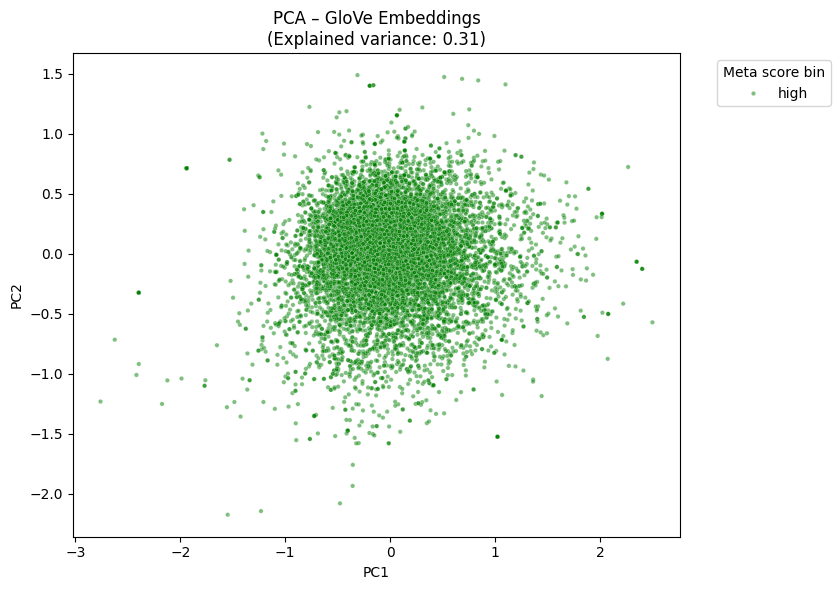

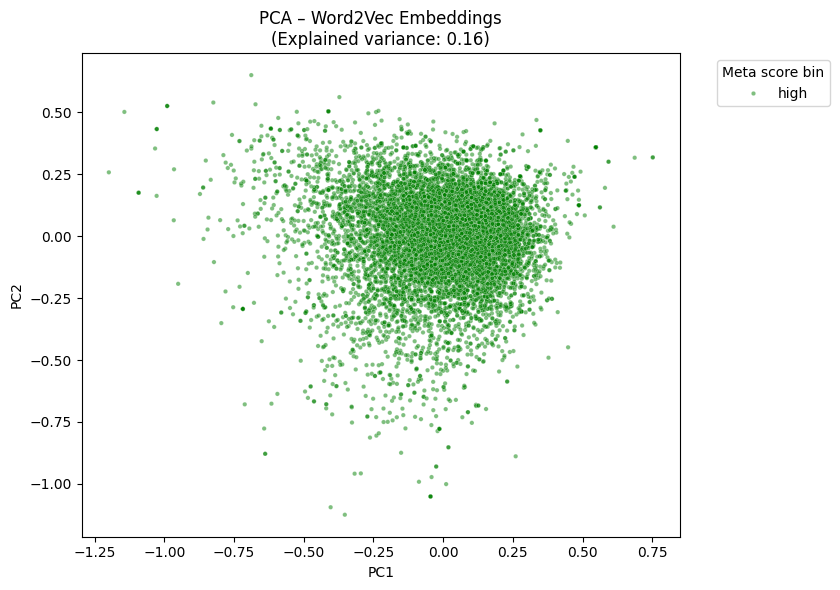

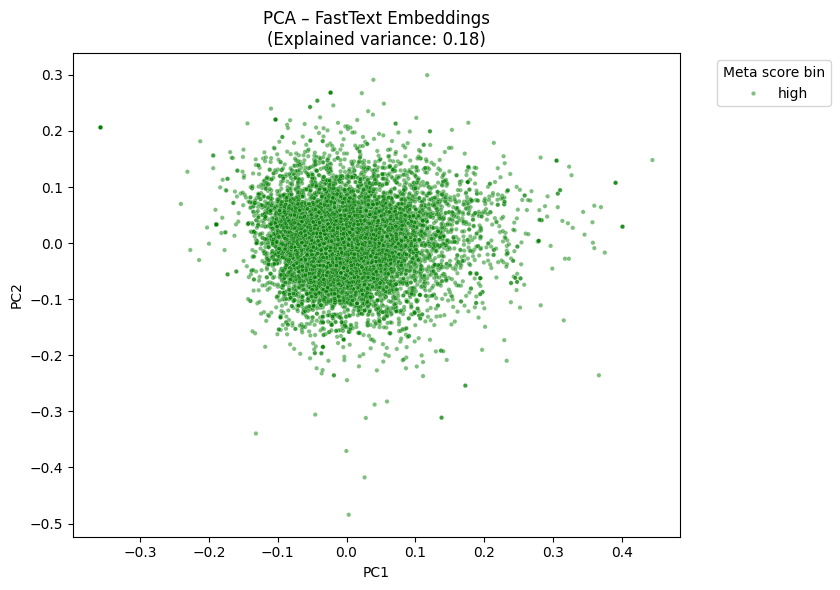

In [ ]:
# Run PCA for all embeddings
pca_scatter(glove_vectors, "PCA – GloVe Embeddings")
pca_scatter(w2v_vectors, "PCA – Word2Vec Embeddings")
pca_scatter(ft_vectors,  "PCA – FastText Embeddings")

## t-SNE Visualization (FastText only)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.004s...
[t-SNE] Computed neighbors for 2000 samples in 0.791s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.052888
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.311592
[t-SNE] KL divergence after 1000 iterations: 2.375519


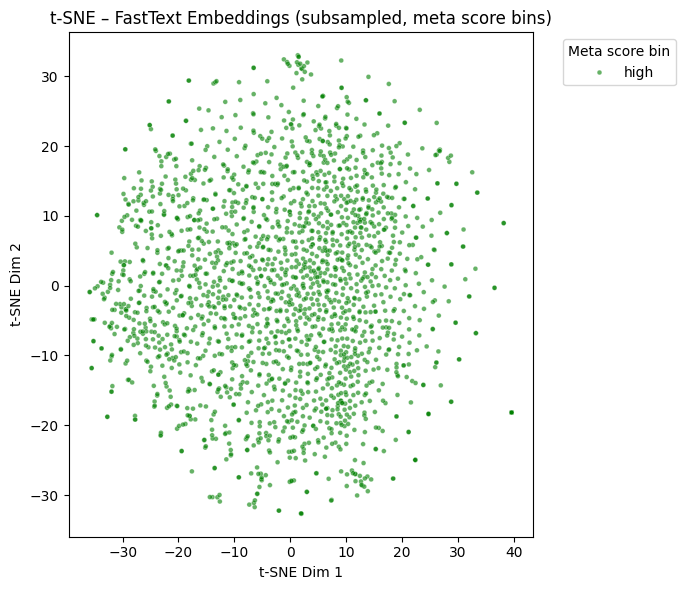

In [ ]:
from sklearn.manifold import TSNE

tsne_sample = min(2000, ft_vectors.shape[0])
tsne_idx = np.random.choice(ft_vectors.shape[0], tsne_sample, replace=False)

X_tsne = ft_vectors[tsne_idx]
y_tsne = df_en['meta_bin'].iloc[tsne_idx].reset_index(drop=True)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    verbose=1,
    random_state=42
)
X_emb_tsne = tsne.fit_transform(X_tsne)

plt.figure(figsize=(7, 6))
sns.scatterplot(
    x=X_emb_tsne[:, 0],
    y=X_emb_tsne[:, 1],
    hue=y_tsne,
    palette=palette,
    alpha=0.6,
    s=12
)
plt.title("t-SNE – FastText Embeddings (subsampled, meta score bins)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(title="Meta score bin", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np

# Correct folder where you want to save files
save_dir = "/content/drive/MyDrive/NLP_FINAL/dataset"

# Create folder if it doesn’t exist
os.makedirs(save_dir, exist_ok=True)

print("Files will be saved to:", save_dir)

Files will be saved to: /content/drive/MyDrive/NLP_FINAL/dataset


In [ ]:
# Save GloVe Wiki Gigaword 50
glove_csv_path = f"{save_dir}/gloveWiki50_vectors.csv"
glove_df.to_csv(glove_csv_path, index=False)
print("GloVe CSV saved:", glove_csv_path)

GloVe CSV saved: /content/drive/MyDrive/NLP_FINAL/dataset/gloveWiki50_vectors.csv


In [ ]:
# Save FastText
ft_csv_path = f"{save_dir}/fasttext_vectors.csv"
ft_df.to_csv(ft_csv_path, index=False)

ft_np_path = f"{save_dir}/fasttext_vectors.npy"
np.save(ft_np_path, ft_vectors)

In [ ]:
# Save Word2Vec
w2v_csv_path = f"{save_dir}/word2vec_vectors.csv"
w2v_df.to_csv(w2v_csv_path, index=False)

w2v_np_path = f"{save_dir}/word2vec_vectors.npy"
np.save(w2v_np_path, w2v_vectors)

print("Word2Vec saved:", w2v_csv_path)
print("Word2Vec NumPy saved:", w2v_np_path)

Word2Vec saved: /content/drive/MyDrive/NLP_FINAL/dataset/word2vec_vectors.csv
Word2Vec NumPy saved: /content/drive/MyDrive/NLP_FINAL/dataset/word2vec_vectors.npy


# Task 4: Sentiment Analysis

### Load the Dataset

In [ ]:
import pandas as pd

In [ ]:
# Load the English-only review dataset
path = "/content/drive/MyDrive/NLP_FINAL/dataset/games_reviews_ENGLISH.csv"
df_en = pd.read_csv(path)

In [ ]:
df_en.head()

,Unnamed: 0,game,avg_user_score,meta_score,user_score,review,lang,word_count
0,1,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,"I loved this game the whole way through, even ...",en,130
1,2,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,[SPOILER ALERT: This review contains spoilers.],en,6
2,3,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,Hyrule Warriors: Age of Imprisonment stands ou...,en,339
3,4,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10.0,"I normally do not enjoy these kind of games, b...",en,70
4,5,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10.0,I have played Hyrule Warriors on the 3DS and n...,en,337


In [ ]:
# Install TextBlob for polarity & subjectivity scores
!pip install textblob

In [ ]:
# Import required libraries
from textblob import TextBlob
from textblob import Word
import nltk

# Download VADER lexicon for NLTK
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
df_sa = df_en[['normalized_meta_score', 'normalized_user_score', 'review_expanded']].copy()
df_sa['polarity'] = df_sa['review_expanded'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_sa['subjectivity'] = df_sa['review_expanded'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
sia = SentimentIntensityAnalyzer()
df_sa['compound'] = df_sa['review_expanded'].apply(lambda row: sia.polarity_scores(row)['compound'])
df_sa.head()

,normalized_meta_score,normalized_user_score,review_expanded,polarity,subjectivity,compound
0,0.58,0.8,"I loved this game the whole way through, even ...",0.196257,0.581150,0.9709
1,0.58,0.8,[SPOILER ALERT: This review contains spoilers.],0.000000,0.000000,0.4466
2,0.58,0.8,Hyrule Warriors: Age of Imprisonment stands ou...,0.244562,0.493643,0.9946
3,0.58,1.0,"I normally do not enjoy these kind of games, b...",0.296667,0.625556,0.9679
4,0.58,1.0,I have played Hyrule Warriors on the 3DS and n...,0.181261,0.556989,0.9982


In [ ]:
df_sa[['polarity','subjectivity','compound','normalized_meta_score']].corr()
df_sa[['polarity','subjectivity','compound','normalized_user_score']].corr()

,polarity,subjectivity,compound,normalized_user_score
polarity,1.000000,0.200705,0.509792,0.509972
subjectivity,0.200705,1.000000,0.066128,0.024053
compound,0.509792,0.066128,1.000000,0.541757
normalized_user_score,0.509972,0.024053,0.541757,1.000000


In [ ]:
# snapshot
file_name = 'dataset/sa.csv'
df_sa.to_csv(file_name, index=False)

In [ ]:
#HWT

# Task 5: Topic Modeling

In [ ]:
import pandas as pd

In [ ]:
# Load your processed dataset
lemmas_path = "/content/drive/MyDrive/NLP_FINAL/dataset/games_reviews_lemmas_final.csv"
df_lemmas = pd.read_csv(lemmas_path)

In [ ]:
print("Columns:", df_lemmas.columns.tolist())
df_lemmas.head()

Columns: ['Unnamed: 0', 'game', 'avg_user_score', 'meta_score', 'user_score', 'review', 'lang', 'word_count', 'review_expanded', 'review_tokens', 'clean_tokens', 'pos_tags', 'lemmas']


,Unnamed: 0,game,avg_user_score,meta_score,user_score,review,lang,word_count,review_expanded,review_tokens,clean_tokens,pos_tags,lemmas
0,1,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,"I loved this game the whole way through, even ...",en,130,"I loved this game the whole way through, even ...","['I', 'loved', 'this', 'game', 'the', 'whole',...","['loved', 'game', 'whole', 'way', 'even', 'som...","[('loved', 'VERB'), ('game', 'NOUN'), ('whole'...","['love', 'game', 'way', 'despise', 'age', 'cal..."
1,2,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,[SPOILER ALERT: This review contains spoilers.],en,6,[SPOILER ALERT: This review contains spoilers.],"['[', 'SPOILER', 'ALERT', ':', 'This', 'review...","['spoiler', 'alert', 'review', 'contains', 'sp...","[('spoiler', 'PROPN'), ('alert', 'NOUN'), ('re...","['spoiler', 'alert', 'review', 'contain', 'spo..."
2,3,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,Hyrule Warriors: Age of Imprisonment stands ou...,en,339,Hyrule Warriors: Age of Imprisonment stands ou...,"['Hyrule', 'Warriors', ':', 'Age', 'of', 'Impr...","['hyrule', 'warriors', 'age', 'imprisonment', ...","[('hyrule', 'NOUN'), ('warriors', 'NOUN'), ('a...","['hyrule', 'warrior', 'age', 'imprisonment', '..."
3,4,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10.0,"I normally do not enjoy these kind of games, b...",en,70,"I normally do not enjoy these kind of games, b...","['I', 'normally', 'do', 'not', 'enjoy', 'these...","['normally', 'enjoy', 'kind', 'games', 'one', ...","[('normally', 'ADV'), ('enjoy', 'VERB'), ('kin...","['normally', 'enjoy', 'kind', 'game', 'surpris..."
4,5,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10.0,I have played Hyrule Warriors on the 3DS and n...,en,337,I have played Hyrule Warriors on the 3DS and n...,"['I', 'have', 'played', 'Hyrule', 'Warriors', ...","['played', 'hyrule', 'warriors', 'never', 'mad...","[('played', 'VERB'), ('hyrule', 'NOUN'), ('war...","['play', 'hyrule', 'warrior', 'far', 'like', '..."


In [ ]:
# Setup & Load Lemma Dataset
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Installing Topic modeling libraries
!pip install gensim -q
!pip install -U pyLDAvis -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 31.2 MB/s eta 0:00:00


In [ ]:
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases, Phraser

In [ ]:
import pyLDAvis
import pyLDAvis.gensim

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from IPython.utils.io import capture_output

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Suppress Deprecation warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Load the processed lemmas file from Google Drive
lemmas_path = "/content/drive/MyDrive/NLP_FINAL/dataset/games_reviews_lemmas_final.csv"
df_lemmas = pd.read_csv(lemmas_path)

In [ ]:
# Check output
print("Columns:", df_lemmas.columns.tolist())
df_lemmas.head(3)

Columns: ['Unnamed: 0', 'game', 'avg_user_score', 'meta_score', 'user_score', 'review', 'lang', 'word_count', 'review_expanded', 'review_tokens', 'clean_tokens', 'pos_tags', 'lemmas']


,Unnamed: 0,game,avg_user_score,meta_score,user_score,review,lang,word_count,review_expanded,review_tokens,clean_tokens,pos_tags,lemmas
0,1,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,"I loved this game the whole way through, even ...",en,130,"I loved this game the whole way through, even ...","['I', 'loved', 'this', 'game', 'the', 'whole',...","['loved', 'game', 'whole', 'way', 'even', 'som...","[('loved', 'VERB'), ('game', 'NOUN'), ('whole'...","['love', 'game', 'way', 'despise', 'age', 'cal..."
1,2,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,[SPOILER ALERT: This review contains spoilers.],en,6,[SPOILER ALERT: This review contains spoilers.],"['[', 'SPOILER', 'ALERT', ':', 'This', 'review...","['spoiler', 'alert', 'review', 'contains', 'sp...","[('spoiler', 'PROPN'), ('alert', 'NOUN'), ('re...","['spoiler', 'alert', 'review', 'contain', 'spo..."
2,3,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,Hyrule Warriors: Age of Imprisonment stands ou...,en,339,Hyrule Warriors: Age of Imprisonment stands ou...,"['Hyrule', 'Warriors', ':', 'Age', 'of', 'Impr...","['hyrule', 'warriors', 'age', 'imprisonment', ...","[('hyrule', 'NOUN'), ('warriors', 'NOUN'), ('a...","['hyrule', 'warrior', 'age', 'imprisonment', '..."


In [ ]:
# Ensure 'lemmas' is a list of tokens
# (When reading from CSV, it's often a string like "['love','game',...]")
import ast

def ensure_list(x):
    # if it's already a list, return as-is
    if isinstance(x, list):
        return x
    # otherwise safely parse the string representation
    try:
        return ast.literal_eval(x)
    except Exception:
        # fallback: split on spaces just in case
        return str(x).split()

df_lemmas['lemmas'] = df_lemmas['lemmas'].apply(ensure_list)

In [ ]:
# Quick check
df_lemmas[['lemmas']].head(3)

,lemmas
0,"[love, game, way, despise, age, calamity, game..."
1,"[spoiler, alert, review, contain, spoiler]"
2,"[hyrule, warrior, age, imprisonment, stand, op..."


In [ ]:
# Create a text column like professor's df['Review_Final']
# Simply join lemmas with spaces.
df_lemmas['Review_Final'] = df_lemmas['lemmas'].apply(lambda toks: " ".join(toks))

df_lemmas[['Review_Final', 'lemmas']].head(3)

,Review_Final,lemmas
0,love game way despise age calamity game phenom...,"[love, game, way, despise, age, calamity, game..."
1,spoiler alert review contain spoiler,"[spoiler, alert, review, contain, spoiler]"
2,hyrule warrior age imprisonment stand opinion ...,"[hyrule, warrior, age, imprisonment, stand, op..."


## 1. Bag-of-Words & TF-IDF Matrices (Sklearn)

### 1.1 Frequency BOW

In [ ]:
# Frequency-based Bag-of-Words (BOW)
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer with same parameters
vectorize_freq = CountVectorizer(
    max_features=1000,
    stop_words="english",
    max_df=0.75,
    min_df=0.01
)

In [ ]:
# Fit on Review_Final and transform to sparse matrix
matrix_freq = vectorize_freq.fit_transform(df_lemmas['Review_Final'])

In [ ]:
# Convert sparse matrix to DataFrame for BOW-frequency mode
%time
df_bow_freq = pd.DataFrame(
    matrix_freq.toarray(),
    index = df_lemmas.index,
    columns = vectorize_freq.get_feature_names_out()
)

df_bow_freq.head()

CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 18.8 µs


,aaa,ability,able,absolute,absolutely,act,action,actual,actually,add,addictive,addition,adventure,ago,alan,alive,allow,amazing,animation,annoying,appreciate,arc,arcade,area,art,ask,aspect,astro,atlus,atmosphere,attack,attention,away,awesome,awful,bad,balance,base,basically,battle,beat,beautiful,beautifully,begin,believe,big,bit,blend,blow,bore,boring,boss,bot,break,brilliant,bring,bug,build,building,button,buy,capcom,captivate,car,care,case,cast,cat,certain,challenge,challenging,change,chapter,character,charm,choice,choose,city,class,classic,clear,close,combat,combine,come,compare,complaint,complete,completely,complex,consider,console,constantly,contain,content,continue,control,cool,core,couple,course,craft,crazy,create,creative,cutscene,damage,dark,day,decent,decide,decision,deep,definitely,deliver,demon,depth,deserve,design,despite,develop,developer,development,devs,dialogue,die,different,difficult,difficulty,direction,disappoint,discover,dlc,doubt,dragon,draw,drive,drop,dungeon,dynamic,early,easily,easy,effect,elden,element,emotion,emotional,encounter,end,ending,enemy,engage,engine,enhance,enjoy,enjoyable,entire,entry,environment,epic,especially,evil,exactly,example,excellent,exciting,expand,expect,expectation,experience,exploration,explore,extra,extraction,extremely,face,fact,fair,fall,fan,fantastic,fantasy,far,fast,favorite,favourite,feature,feel,feeling,fight,fighter,fighting,final,finally,fine,finish,fit,fix,flaw,focus,follow,force,forget,forward,forza,franchise,free,freedom,fresh,friend,fromsoftware,frustrating,fully,fun,funny,future,gameplay,gamer,games,gaming,general,genre,genuinely,god,good,gorgeous,goty,graphic,great,grind,guy,hade,half,hand,happen,happy,hard,hate,hear,heart,help,hide,high,highly,hill,history,hit,hold,hollow,honest,honestly,hope,horizon,horror,hour,huge,hype,idea,immersion,immersive,important,impressive,improve,improvement,include,incredible,incredibly,indie,insane,instead,interaction,interesting,issue,item,job,journey,joy,jrpg,jump,kill,kind,knight,know,lack,late,later,lead,learn,leave,let,level,life,light,like,line,literally,little,live,location,long,look,loop,lore,lose,lot,love,low,main,major,make,man,manage,map,massive,master,masterpiece,match,matter,maybe,mean,mechanic,memorable,mention,mess,mind,mini,minor,minute,miss,mission,mix,mode,modern,moment,money,movement,movie,multiple,music,narrative,near,need,negative,new,nice,non,notch,npc,offer,old,online,open,opinion,option,original,outstanding,overall,pace,pass,past,pay,peak,people,perfect,perfectly,performance,person,persona,personal,personally,phenomenal,pick,piece,place,platformer,platinum,play,player,playing,playstation,playthrough,plot,plus,point,polished,poor,possible,potential,power,praise,prefer,present,pretty,previous,price,pro,probably,problem,progress,progression,protagonist,provide,pure,push,puzzle,quality,quest,quickly,race,racing,raider,rare,rating,reach,read,real,reason,rebirth,recommend,release,remain,remake,remember,remind,repeat,repetitive,replay,require,resident,rest,return,review,reward,rewarding,rich,right,ring,rogue,room,royal,rpg,rpgs,ruin,run,rush,saga,satisfy,save,say,scene,score,screen,second,secret,section,sense,sequel,series,set,shadow,shooter,short,silent,silksong,similar,simple,simply,single,skill,slow,small,smooth,solid,soon,soul,sound,soundtrack,space,special,spend,spider,spoiler,stand,standard,start,stay,step,stick,stop,story,storyline,storytelle,strategy,street,strong,studio,stuff,stunning,style,super,support,sure,surprise,survival,switch,talk,team,technical,tedious,tell,term,terrible,thank,theme,thing,think,thought,throw,time,title,ton,track,true,truly,try,turn,twist,type,understand,unfortunately,unique,update,upgrade,use,usually,variety,version,video,visual,visually,voice,wait,wake,walk,want,war,waste,watch,way,weak,weapon,weird,win,wish,wonderful,word,work,world,worth,write,wrong,yakuza,year,yes
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,

## 1.2 One-Hot BOW (Binary)

In [ ]:
# One-hot (binary) Bag-of-Words
vectorize_BOW = CountVectorizer(
    max_features=1000,
    stop_words="english",
    max_df=0.75,
    min_df=0.01,
    binary=True
)

In [ ]:
matrix_BOW = vectorize_BOW.fit_transform(df_lemmas['Review_Final'])

In [ ]:
df_BOW = pd.DataFrame(
    matrix_BOW.toarray(),
    index=np.arange(len(df_lemmas)),
    columns=vectorize_BOW.get_feature_names_out()
)

df_BOW.head(3), df_BOW.shape

(   aaa  ability  able  absolute  absolutely  act  action  actual  actually  \
 0    0        0     0         0           0    0       0       0         0   
 1    0        0     0         0           0    0       0       0         0   
 2    0        0     0         0           1    0       0       0         1   
 
    add  addictive  addition  adventure  ago  alan  alive  allow  amazing  \
 0    0          0         0          0    0     0      0      0        0   
 1    0          0         0          0    0     0      0      0        0   
 2    1          0         0          0    0     0      0      0        0   
 
    animation  annoying  appreciate  arc  arcade  area  art  ask  aspect  \
 0          0         0           0    0       0     0    0    0       0   
 1          0         0           0    0       0     0    0    0       0   
 2          0         0           0    0       0     0    1    0       0   
 
    astro  atlus  atmosphere  attack  attention  away  awesome  aw

## 1.3 TF-IDF Matrix

In [ ]:
# TF-IDF Representation
from sklearn.feature_extraction.text import TfidfVectorizer

vectorize_tf = TfidfVectorizer(
    stop_words="english",
    max_features=1000,
    max_df=0.75,
    min_df=0.01,
    smooth_idf=True
)

In [ ]:
%time
matrix_tfidf = vectorize_tf.fit_transform(df_lemmas['Review_Final'])

df_tfidf = pd.DataFrame(
    matrix_tfidf.toarray(),
    index=np.arange(len(df_lemmas)),
    columns=vectorize_tf.get_feature_names_out()
)

df_tfidf.head(3)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.11 µs


,aaa,ability,able,absolute,absolutely,act,action,actual,actually,add,addictive,addition,adventure,ago,alan,alive,allow,amazing,animation,annoying,appreciate,arc,arcade,area,art,ask,aspect,astro,atlus,atmosphere,attack,attention,away,awesome,awful,bad,balance,base,basically,battle,beat,beautiful,beautifully,begin,believe,big,bit,blend,blow,bore,boring,boss,bot,break,brilliant,bring,bug,build,building,button,buy,capcom,captivate,car,care,case,cast,cat,certain,challenge,challenging,change,chapter,character,charm,choice,choose,city,class,classic,clear,close,combat,combine,come,compare,complaint,complete,completely,complex,consider,console,constantly,contain,content,continue,control,cool,core,couple,course,craft,crazy,create,creative,cutscene,damage,dark,day,decent,decide,decision,deep,definitely,deliver,demon,depth,deserve,design,despite,develop,developer,development,devs,dialogue,die,different,difficult,difficulty,direction,disappoint,discover,dlc,doubt,dragon,draw,drive,drop,dungeon,dynamic,early,easily,easy,effect,elden,element,emotion,emotional,encounter,end,ending,enemy,engage,engine,enhance,enjoy,enjoyable,entire,entry,environment,epic,especially,evil,exactly,example,excellent,exciting,expand,expect,expectation,experience,exploration,explore,extra,extraction,extremely,face,fact,fair,fall,fan,fantastic,fantasy,far,fast,favorite,favourite,feature,feel,feeling,fight,fighter,fighting,final,finally,fine,finish,fit,fix,flaw,focus,follow,force,forget,forward,forza,franchise,free,freedom,fresh,friend,fromsoftware,frustrating,fully,fun,funny,future,gameplay,gamer,games,gaming,general,genre,genuinely,god,good,gorgeous,goty,graphic,great,grind,guy,hade,half,hand,happen,happy,hard,hate,hear,heart,help,hide,high,highly,hill,history,hit,hold,hollow,honest,honestly,hope,horizon,horror,hour,huge,hype,idea,immersion,immersive,important,impressive,improve,improvement,include,incredible,incredibly,indie,insane,instead,interaction,interesting,issue,item,job,journey,joy,jrpg,jump,kill,kind,knight,know,lack,late,later,lead,learn,leave,let,level,life,light,like,line,literally,little,live,location,long,look,loop,lore,lose,lot,love,low,main,major,make,man,manage,map,massive,master,masterpiece,match,matter,maybe,mean,mechanic,memorable,mention,mess,mind,mini,minor,minute,miss,mission,mix,mode,modern,moment,money,movement,movie,multiple,music,narrative,near,need,negative,new,nice,non,notch,npc,offer,old,online,open,opinion,option,original,outstanding,overall,pace,pass,past,pay,peak,people,perfect,perfectly,performance,person,persona,personal,personally,phenomenal,pick,piece,place,platformer,platinum,play,player,playing,playstation,playthrough,plot,plus,point,polished,poor,possible,potential,power,praise,prefer,present,pretty,previous,price,pro,probably,problem,progress,progression,protagonist,provide,pure,push,puzzle,quality,quest,quickly,race,racing,raider,rare,rating,reach,read,real,reason,rebirth,recommend,release,remain,remake,remember,remind,repeat,repetitive,replay,require,resident,rest,return,review,reward,rewarding,rich,right,ring,rogue,room,royal,rpg,rpgs,ruin,run,rush,saga,satisfy,save,say,scene,score,screen,second,secret,section,sense,sequel,series,set,shadow,shooter,short,silent,silksong,similar,simple,simply,single,skill,slow,small,smooth,solid,soon,soul,sound,soundtrack,space,special,spend,spider,spoiler,stand,standard,start,stay,step,stick,stop,story,storyline,storytelle,strategy,street,strong,studio,stuff,stunning,style,super,support,sure,surprise,survival,switch,talk,team,technical,tedious,tell,term,terrible,thank,theme,thing,think,thought,throw,time,title,ton,track,true,truly,try,turn,twist,type,understand,unfortunately,unique,update,upgrade,use,usually,variety,version,video,visual,visually,voice,wait,wake,walk,want,war,waste,watch,way,weak,weapon,weird,win,wish,wonderful,word,work,world,worth,write,wrong,yakuza,year,yes
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

## 2. LSA with Sklearn (SVD)

### 2.1 LSA on BOW

In [ ]:
# LSA with BOW (Sklearn TruncatedSVD)
from sklearn.decomposition import TruncatedSVD

n_topics = 8  # same as professor

svd_model_bow = TruncatedSVD(
    n_components=n_topics,
    algorithm='randomized',
    n_iter=100,
    random_state=122
)

In [ ]:
# Fit on BOW matrix
%time
svd_model_bow.fit(matrix_BOW)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


TruncatedSVD(n_components=8, n_iter=100, random_state=122)

In [ ]:
# Print top 15 words for each topic
for i, component in enumerate(svd_model_bow.components_):
    terms_comp = zip(vectorize_BOW.get_feature_names_out(), component)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:15]
    print(f"Topic {i}: ")
    for t in sorted_terms:
        print(t[0], end=" ")
    print("\n")

Topic 0: 
play good like story feel time character gameplay great fun world new combat way experience 

Topic 1: 
good play story gameplay amazing graphic great love fun masterpiece music year persona goty perfect 

Topic 2: 
story gameplay character combat great music world experience amazing visual narrative soundtrack turn masterpiece graphic 

Topic 3: 
good boss design world fight enemy level ring elden dlc challenge difficulty soul exploration weapon 

Topic 4: 
play experience world masterpiece design visual player stunning truly challenge offer combat fan narrative perfect 

Topic 5: 
like feel experience good masterpiece gameplay make narrative visual atmosphere year stunning truly love moment 

Topic 6: 
gameplay great fun graphic like design amazing feel level boss sound challenge soul visual beautiful 

Topic 7: 
fun world boss like feel combat play open design fight story level elden ring challenge 



## 2.2 LSA on TF-IDF

In [ ]:
# LSA with TF-IDF
svd_model_tfidf = TruncatedSVD(
    n_components=n_topics,
    algorithm='randomized',
    n_iter=100,
    random_state=122
)

In [ ]:
%time
svd_model_tfidf.fit(matrix_tfidf)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


TruncatedSVD(n_components=8, n_iter=100, random_state=122)

In [ ]:
for i, component in enumerate(svd_model_tfidf.components_):
    terms_comp = zip(vectorize_tf.get_feature_names_out(), component)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:15]
    print(f"Topic {i}: ")
    for t in sorted_terms:
        print(t[0], end=" ")
    print("\n")

Topic 0: 
good play story like great time feel gameplay character fun love amazing world combat new 

Topic 1: 
good play year amazing graphic masterpiece remake goty horror jrpg resident life probably history evil 

Topic 2: 
great story gameplay amazing character graphic music combat beautiful perfect soundtrack awesome art love incredible 

Topic 3: 
play great love fun hour year amazing time absolutely recommend enjoy want buy original friend 

Topic 4: 
remake original great silent hill masterpiece resident soul evil horror graphic new atmosphere perfect fan 

Topic 5: 
great boss dlc good time fun fight soul elden ring challenge lot car bad hard 

Topic 6: 
like feel great story persona bad good remake character original review look boring yakuza spoiler 

Topic 7: 
love like great good cat boss soul dlc nice feel persona think fun knight playing 



## 3. LSA with Gensim + Coherence

### 3.1 Prepare Gensim Corpus

In [ ]:
# Prepare texts, dictionary, and corpus for Gensim
# texts = list of token lists (we already have lemmas)
texts = df_lemmas['lemmas'].tolist()

In [ ]:
# id2word: mapping between token IDs and tokens
id2word = corpora.Dictionary(texts)

In [ ]:
# BOW corpus (list of list of (token_id, count))
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
print(texts[0][:20])
print(corpus[0][:10])

['love', 'game', 'way', 'despise', 'age', 'calamity', 'game', 'phenomenal', 'tell', 'unknown', 'botw', 'totk', 'lore', 'think', 'game', 'perfect', 'time', 'goodbye', 'botw', 'era']
[(0, 1), (1, 1), (2, 1), (3, 4), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


## 3.2 LSA (BOW) with Gensim

In [ ]:
# LSA with BOW (Gensim)
def create_gensim_lsa(corpus, id2word, n_topics, n_words=15):
    """
    Create a Gensim LSA model and print topics.
    """
    lsa_model = models.LsiModel(
        corpus,
        id2word=id2word,
        num_topics=n_topics
    )

    topics = lsa_model.show_topics(
        num_topics=n_topics,
        num_words=n_words,
        formatted=True
    )
    for topic in topics:
        print("Topic", topic[0], ":", topic[1])

    return lsa_model

In [ ]:
n_topics = 8
lsi_model_bow = create_gensim_lsa(corpus, id2word, n_topics=n_topics, n_words=15)

Topic 0 : 0.816*"game" + 0.187*"like" + 0.170*"play" + 0.153*"good" + 0.145*"story" + 0.127*"feel" + 0.117*"character" + 0.115*"time" + 0.080*"gameplay" + 0.077*"great" + 0.074*"world" + 0.073*"new" + 0.070*"boss" + 0.068*"fun" + 0.062*"combat"
Topic 1 : -0.499*"game" + 0.411*"feel" + 0.291*"like" + 0.235*"story" + 0.204*"character" + 0.167*"boss" + 0.158*"time" + 0.148*"world" + 0.132*"combat" + 0.120*"new" + 0.111*"fight" + 0.102*"way" + 0.102*"gameplay" + 0.098*"experience" + 0.095*"design"
Topic 2 : -0.567*"story" + -0.332*"character" + 0.314*"boss" + -0.300*"good" + 0.249*"like" + 0.186*"feel" + -0.180*"gameplay" + -0.111*"combat" + -0.103*"persona" + 0.103*"player" + -0.099*"great" + 0.093*"soul" + -0.088*"play" + 0.086*"elden" + 0.085*"ring"
Topic 3 : -0.554*"good" + -0.504*"play" + -0.306*"like" + 0.201*"game" + 0.187*"world" + 0.172*"story" + 0.153*"character" + 0.092*"boss" + -0.085*"thing" + 0.082*"combat" + 0.082*"experience" + -0.081*"lot" + 0.069*"elden" + 0.066*"ring" + 

## 3.3 LSA (TF-IDF) + Coherence

In [ ]:
# LSA with TF-IDF and Coherence
# Build TF-IDF model on BOW corpus
tfidf = models.TfidfModel(corpus)

%time
corpus_tfidf = tfidf[corpus]

# LSA on TF-IDF corpus
lsi_model_tfidf = models.LsiModel(
    corpus_tfidf,
    id2word=id2word,
    num_topics=n_topics
)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


In [ ]:
# Coherence for both BOW and TF-IDF LSA
coherence_model_lsi_idf = CoherenceModel(
    model=lsi_model_tfidf,
    texts=texts,
    dictionary=id2word,
    coherence='c_v'
)
coh_lsi_idf = coherence_model_lsi_idf.get_coherence()

coherence_model_lsi_bow = CoherenceModel(
    model=lsi_model_bow,
    texts=texts,
    dictionary=id2word,
    coherence='c_v'
)
coh_lsi_bow = coherence_model_lsi_bow.get_coherence()

In [ ]:
print("LSA (BOW) coherence:", coh_lsi_bow)
print("LSA (TF-IDF) coherence:", coh_lsi_idf)

LSA (BOW) coherence: 0.3885118670305199
LSA (TF-IDF) coherence: 0.3723615033640709


## 3.4 Coherence vs Number of Topics (LSA)

In [ ]:
# Scan coherence over different topic numbers (LSA)
def compute_coherence_scores(id2word, corpus, texts, stop, start=2, step=2,
                             coherence_measure='c_v'):
    coherence_scores = []
    model_list = []

    for n_topics in range(start, stop + 1, step):
        lsa_model = models.LsiModel(
            corpus,
            id2word=id2word,
            num_topics=n_topics
        )

        model_list.append(lsa_model)

        coherence_model_lsa = CoherenceModel(
            model=lsa_model,
            texts=texts,
            dictionary=id2word,
            coherence=coherence_measure
        )

        coherence_scores.append(coherence_model_lsa.get_coherence())

    return model_list, coherence_scores

In [ ]:
lsa_models, lsa_scores = compute_coherence_scores(
    id2word=id2word,
    corpus=corpus_tfidf,
    texts=texts,
    stop=20,
    start=2,
    step=2,
    coherence_measure='c_v'
)

In [ ]:
# Clean formatted output
for k, score in zip(range(2, 21, 2), lsa_scores):
    print(f"Topics = {k}: Coherence = {score:.4f}")

Topics = 2: Coherence = 0.3398
Topics = 4: Coherence = 0.3672
Topics = 6: Coherence = 0.3833
Topics = 8: Coherence = 0.3812
Topics = 10: Coherence = 0.3602
Topics = 12: Coherence = 0.3106
Topics = 14: Coherence = 0.3141
Topics = 16: Coherence = 0.3211
Topics = 18: Coherence = 0.3193
Topics = 20: Coherence = 0.3105


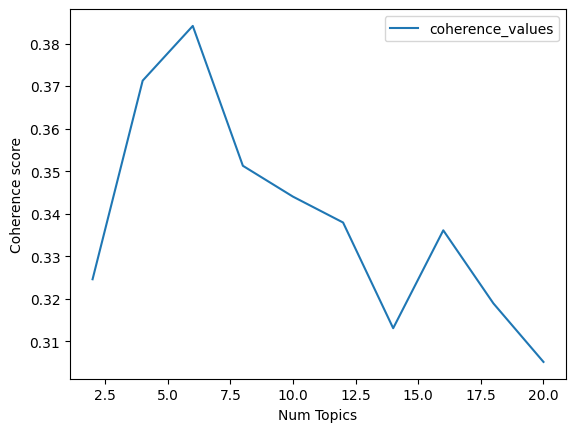

In [ ]:
# Plot coherence values
x = range(2, 21, 2)
plt.plot(x, lsa_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values",), loc='best')
plt.show()

## Based on out plot:

Best LSA topic count = 6 topics

Coherence ~ 0.383, highest in the curve

Topics after 10 sharply decrease → model becomes less stable

For LSA, coherence analysis showed that a 6-topic model produced the highest coherence score (≈0.383). This suggests that 6 latent themes best capture the semantic structure of the game review corpus.

## 4. LDA Topic Modeling (Gensim + pyLDAvis)

### 4.1 Prepare Bigrams and Filtered Dictionary

In [ ]:
# Build bigrams and filtered corpus for LDA
# Base sentences: tokenized lemmas
sent = texts  # each item already a list of tokens

In [ ]:
# Learn bigram model (min_count similar to professor; we can adjust if needed)
bigram = Phrases(sent, min_count=40)
bigram_phraser = Phraser(bigram)

In [ ]:
# Apply bigram model to each document
texts_lda = bigram_phraser[sent]

In [ ]:
# Build dictionary
id2word_lda = Dictionary(texts_lda)

In [ ]:
# Filter very frequent and very rare tokens
id2word_lda.filter_extremes(no_below=40, no_above=0.75)

In [ ]:
# Build corpus for LDA
corpus_lda = [id2word_lda.doc2bow(text) for text in texts_lda]

In [ ]:
len(id2word_lda), len(corpus_lda)

(1303, 10488)

In [ ]:
print(texts_lda[0][:20])
print(corpus_lda[0][:10])

['love', 'game', 'way', 'despise', 'age', 'calamity', 'game', 'phenomenal', 'tell', 'unknown', 'botw', 'totk', 'lore', 'think', 'game', 'perfect', 'time', 'goodbye', 'botw', 'era']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


## 4.2 Train Base LDA Model (e.g., 8 topics)

In [ ]:
# Train initial LDA model (8 topics)
num_topics = 8
chunksize = 100
passes = 20
iterations = 400
eval_every = None

lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus_lda,
    id2word=id2word_lda,
    chunksize=chunksize,
    passes=passes,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    per_word_topics=True,
    eval_every=eval_every
)

In [ ]:
# Print top words per topic
for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=15, formatted=True):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.090*"story" + 0.052*"gameplay" + 0.043*"feel" + 0.043*"character" + 0.036*"combat" + 0.031*"world" + 0.031*"experience" + 0.018*"mechanic" + 0.016*"design" + 0.015*"perfect" + 0.014*"player" + 0.014*"make" + 0.013*"narrative" + 0.012*"short" + 0.011*"rpg"
Topic 1: 0.103*"boring" + 0.088*"buy" + 0.075*"review" + 0.047*"extremely" + 0.047*"enjoyable" + 0.042*"money" + 0.028*"piece" + 0.027*"indie" + 0.027*"lead" + 0.026*"absolute" + 0.025*"awful" + 0.024*"remain" + 0.024*"wake" + 0.020*"disappointing" + 0.020*"crazy"
Topic 2: 0.068*"great" + 0.057*"new" + 0.046*"love" + 0.036*"graphic" + 0.028*"original" + 0.027*"action" + 0.022*"series" + 0.020*"horror" + 0.018*"atmosphere" + 0.018*"fan" + 0.017*"masterpiece" + 0.016*"music" + 0.015*"place" + 0.014*"unique" + 0.013*"version"
Topic 3: 0.055*"fun" + 0.041*"well" + 0.028*"amazing" + 0.028*"end" + 0.025*"level" + 0.022*"overall" + 0.020*"ninja_gaiden" + 0.020*"bit" + 0.019*"pretty" + 0.017*"beautiful" + 0.015*"hard" + 0.014*"diff

## 4.3 Visualize Topics with pyLDAvis

In [ ]:
# Visualize LDA topics using pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus_lda, id2word_lda)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.031117  0.033606       1        1  23.587041
0      0.290787  0.007454       2        1  19.776658
3     -0.099233 -0.236731       3        1  15.364276
2     -0.152742 -0.252718       4        1  14.584718
7     -0.188546  0.317465       5        1   9.408979
5      0.268926  0.026269       6        1   8.665719
4     -0.113247  0.113329       7        1   6.227252
1     -0.037062 -0.008674       8        1   2.385356, topic_info=                 Term         Freq        Total Category  logprob  loglift
88               play  5344.000000  5344.000000  Default  30.0000  30.0000
7                good  5079.000000  5079.000000  Default  29.0000  29.0000
100             story  4781.000000  4781.000000  Default  28.0000  28.0000
8                like  4042.000000  4042.000000  Default  27.0000  27.0000
67              great  2676.000000  2676.000000  Default  26.0000  26.0000
64           gameplay  2748.000000  2748.000000  Default  25.0000  25.0000
12                new  2221.000000  2221.000000  Default  24.0000  24.0000
63                fun  2264.000000  2264.000000  Default  23.0000  23.0000
59               feel  2294.000000  2294.000000  Default  22.0000  22.0000
2           character  2281.000000  2281.000000  Default  21.0000  21.0000
10               love  1809.000000  1809.000000  Default  20.0000  20.0000
21               time  2407.000000  2407.000000  Default  19.0000  19.0000
133              well  1689.000000  1689.000000  Default  18.0000  18.0000
38             combat  1932.000000  1932.000000  Default  17.0000  17.0000
301              year  1170.000000  1170.000000  Default  16.0000  16.0000
121           graphic  1408.000000  1408.000000  Default  15.0000  15.0000
71               hour  1264.000000  1264.000000  Default  14.0000  14.0000
177             world  1663.000000  1663.000000  Default  13.0000  13.0000
1239        alan_wake  1134.000000  1134.000000  Default  12.0000  12.0000
817            boring   659.000000   659.000000  Default  11.0000  11.0000
56         experience  1682.000000  1682.000000  Default  10.0000  10.0000
776            remake   956.000000   956.000000  Default   9.0000   9.0000
1150           puzzle  1565.000000  1565.000000  Default   8.0000   8.0000
116           amazing  1150.000000  1150.000000  Default   7.0000   7.0000
207          original  1113.000000  1113.000000  Default   6.0000   6.0000
403             thing  1485.000000  1485.000000  Default   5.0000   5.0000
22                way  1485.000000  1485.000000  Default   4.0000   4.0000
34                buy   566.000000   566.000000  Default   3.0000   3.0000
178            action  1077.000000  1077.000000  Default   2.0000   2.0000
144               end  1195.000000  1195.000000  Default   1.0000   1.0000
8                like  4041.989196  4042.836910   Topic1  -2.7542   1.4443
21               time  2406.152837  2407.000335   Topic1  -3.2729   1.4441
1150           puzzle  1564.835912  1565.684501   Topic1  -3.7032   1.4439
403             thing  1484.788806  1485.636297   Topic1  -3.7557   1.4439
22                way  1484.655638  1485.503245   Topic1  -3.7558   1.4439
480               bad  1397.018439  1397.866364   Topic1  -3.8166   1.4439
120               get  1283.398967  1284.246517   Topic1  -3.9014   1.4438
78                lot  1244.874675  1245.722222   Topic1  -3.9319   1.4438
161              look  1193.691517  1194.539315   Topic1  -3.9739   1.4438
175              want  1093.910618  1094.758167   Topic1  -4.0612   1.4437
118             enjoy  1080.055606  1080.903282   Topic1  -4.0739   1.4437
20              think  1058.648938  1059.496314   Topic1  -4.0939   1.4437
370              need   975.859592   976.707334   Topic1  -4.1754   1.4436
513         feel_like   956.756691   957.604352   Topic1  -4.1951   1.4436
192             enemy   941.099715   941.9

## 4.4 Coherence Evaluation for LDA

In [ ]:
# Compute coherence for different numbers of topics (LDA)
def compute_lda_coherence_scores(id2word, texts, corpus, stop, start=2, step=2,
                                 coherence_measure='c_v'):
    coherence_score = []
    model_list = []

    for n_topics in range(start, stop + 1, step):
        chunksize = 100
        passes = 20
        iterations = 400
        eval_every = None

        lda_model_temp = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=n_topics,
            random_state=100,
            chunksize=chunksize,
            passes=passes,
            alpha='symmetric',
            eta='symmetric',
            iterations=iterations,
            gamma_threshold=0.001,
            per_word_topics=True,
            eval_every=eval_every
        )

        model_list.append(lda_model_temp)

        coherence_model_lda = CoherenceModel(
            model=lda_model_temp,
            texts=texts,
            dictionary=id2word,
            coherence=coherence_measure
        )

        coherence_score.append(coherence_model_lda.get_coherence())

    return model_list, coherence_score

In [ ]:
lda_models, lda_scores = compute_lda_coherence_scores(
    id2word=id2word_lda,
    texts=texts_lda,
    corpus=corpus_lda,
    stop=14,
    start=2,
    step=2,
    coherence_measure='c_v'
)

In [ ]:
# Clean formatted output
for k, score in zip(range(2, 21, 2), lda_scores):
    print(f"Topics = {k}: Coherence = {score:.4f}")

Topics = 2: Coherence = 0.4112
Topics = 4: Coherence = 0.4166
Topics = 6: Coherence = 0.3457
Topics = 8: Coherence = 0.3548
Topics = 10: Coherence = 0.3353
Topics = 12: Coherence = 0.3353
Topics = 14: Coherence = 0.3540


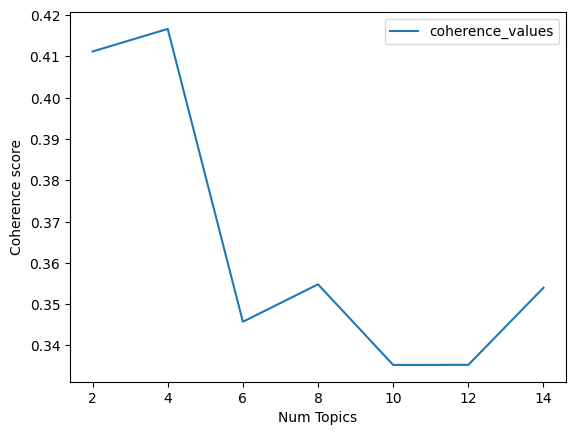

In [ ]:
# Plot LDA coherence vs topic number
x = range(2, 15, 2)
plt.plot(x, lda_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values",), loc='best')
plt.show()

In [ ]:
# Train final LDA model with chosen num_topics
# After looking at the coherence plot, set best_topics accordingly.
best_topics = 4  # <-- update this after seeing our coherence plot

lda_model_final = gensim.models.ldamodel.LdaModel(
    corpus=corpus_lda,
    id2word=id2word_lda,
    chunksize=chunksize,
    passes=passes,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=best_topics,
    per_word_topics=True,
    eval_every=eval_every
)

In [ ]:
for idx, topic in lda_model_final.show_topics(num_topics=best_topics, num_words=15, formatted=True):
    print(f"Final Topic {idx}: {topic}")

Final Topic 0: 0.027*"new" + 0.015*"character" + 0.015*"way" + 0.015*"feel" + 0.014*"make" + 0.014*"player" + 0.012*"feel_like" + 0.011*"find" + 0.009*"overall" + 0.008*"narrative" + 0.008*"point" + 0.008*"short" + 0.008*"give" + 0.008*"especially" + 0.007*"world"
Final Topic 1: 0.076*"like" + 0.028*"thing" + 0.026*"bad" + 0.024*"get" + 0.021*"want" + 0.020*"go" + 0.020*"think" + 0.018*"need" + 0.018*"interesting" + 0.016*"people" + 0.015*"yakuza" + 0.015*"try" + 0.013*"look" + 0.013*"little" + 0.012*"boring"
Final Topic 2: 0.048*"play" + 0.045*"good" + 0.045*"story" + 0.026*"great" + 0.026*"gameplay" + 0.021*"fun" + 0.021*"time" + 0.018*"love" + 0.016*"puzzle" + 0.016*"well" + 0.014*"graphic" + 0.013*"year" + 0.011*"hour" + 0.011*"enjoy" + 0.011*"original"
Final Topic 3: 0.062*"combat" + 0.053*"experience" + 0.033*"feel" + 0.031*"alan_wake" + 0.029*"remake" + 0.029*"mechanic" + 0.027*"horror" + 0.024*"atmosphere" + 0.018*"unique" + 0.017*"truly" + 0.016*"remedy" + 0.015*"silent_hill" 

In [ ]:
# Visualize LDA topics using pyLDAvis
pyLDAvis.enable_notebook()
vis_final = pyLDAvis.gensim.prepare(lda_model_final, corpus_lda, id2word_lda)
vis_final

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.230958  0.121355       1        1  39.137475
0     -0.146703  0.166159       2        1  29.746418
1     -0.012966 -0.408121       3        1  19.698411
3      0.390627  0.120607       4        1  11.417696, topic_info=                 Term         Freq        Total Category  logprob  loglift
8                like  4045.000000  4045.000000  Default  30.0000  30.0000
88               play  5030.000000  5030.000000  Default  29.0000  29.0000
7                good  4780.000000  4780.000000  Default  28.0000  28.0000
100             story  4780.000000  4780.000000  Default  27.0000  27.0000
38             combat  1898.000000  1898.000000  Default  26.0000  26.0000
56         experience  1653.000000  1653.000000  Default  25.0000  25.0000
59               feel  2211.000000  2211.000000  Default  24.0000  24.0000
67              great  2777.000000  2777.000000  Default  23.0000  23.0000
64           gameplay  2748.000000  2748.000000  Default  22.0000  22.0000
12                new  2187.000000  2187.000000  Default  21.0000  21.0000
403             thing  1487.000000  1487.000000  Default  20.0000  20.0000
480               bad  1398.000000  1398.000000  Default  19.0000  19.0000
63                fun  2258.000000  2258.000000  Default  18.0000  18.0000
120               get  1284.000000  1284.000000  Default  17.0000  17.0000
1239        alan_wake  1047.000000  1047.000000  Default  16.0000  16.0000
776            remake   884.000000   884.000000  Default  15.0000  15.0000
205          mechanic   964.000000   964.000000  Default  14.0000  14.0000
175              want  1095.000000  1095.000000  Default  13.0000  13.0000
1181           horror   818.000000   818.000000  Default  12.0000  12.0000
10               love  1877.000000  1877.000000  Default  11.0000  11.0000
20              think  1061.000000  1061.000000  Default  10.0000  10.0000
153                go  1130.000000  1130.000000  Default   9.0000   9.0000
1150           puzzle  1706.000000  1706.000000  Default   8.0000   8.0000
823        atmosphere   724.000000   724.000000  Default   7.0000   7.0000
133              well  1685.000000  1685.000000  Default   6.0000   6.0000
370              need   977.000000   977.000000  Default   5.0000   5.0000
253       interesting   931.000000   931.000000  Default   4.0000   4.0000
434            people   845.000000   845.000000  Default   3.0000   3.0000
435            player  1133.000000  1133.000000  Default   2.0000   2.0000
121           graphic  1461.000000  1461.000000  Default   1.0000   1.0000
88               play  5030.211515  5030.961014   Topic1  -3.0419   0.9379
7                good  4780.223618  4780.968458   Topic1  -3.0928   0.9379
100             story  4779.930833  4780.681354   Topic1  -3.0929   0.9379
67              great  2776.476756  2777.224743   Topic1  -3.6361   0.9378
64           gameplay  2747.351501  2748.107469   Topic1  -3.6467   0.9378
63                fun  2258.114762  2258.870631   Topic1  -3.8428   0.9378
10               love  1877.038982  1877.782606   Topic1  -4.0276   0.9377
133              well  1684.868697  1685.622107   Topic1  -4.1356   0.9376
1150           puzzle  1705.185279  1706.013526   Topic1  -4.1237   0.9376
121           graphic  1460.895998  1461.647359   Topic1  -4.2783   0.9376
301              year  1354.441610  1355.226350   Topic1  -4.3539   0.9375
116           amazing  1147.375488  1148.110693   Topic1  -4.5198   0.9374
207          original  1154.478962  1155.228106   Topic1  -4.5137   0.9374
118             enjoy  1176.988784  1177.754180   Topic1  -4.4944   0.9374
178            action  1117.477355  1118.292803   Topic1  -4.5463   0.9374
160             level  1029.324591  1030.096498   Topic1  -4.6284   0.9373
13            perfect   812.780775   813.527561   Topic1  -4.8646   0.9372
166            pretty   765.52771

# Task 6: Supervised Learning

In [ ]:
# TASK 6 – SUPERVISED LEARNING (NO SVD)
# Predict high vs non-high critic scores
# Imports -----
import pandas as pd
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
)

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
# Load data (adjust paths if needed)
# English reviews with numeric info
en_path = "/content/drive/MyDrive/NLP_FINAL/dataset/games_reviews_ENGLISH.csv"
df_en = pd.read_csv(en_path)

In [ ]:
# Lemmas / cleaned text (adjust paths if needed)
lemmas_path = "/content/drive/MyDrive/NLP_FINAL/dataset/games_reviews_lemmas_final.csv"
df_lemmas = pd.read_csv(lemmas_path)

In [ ]:
print("df_en columns:", df_en.columns.tolist())
print("df_lemmas columns:", df_lemmas.columns.tolist())
print("df_en shape:", df_en.shape, "df_lemmas shape:", df_lemmas.shape)

df_en columns: ['Unnamed: 0', 'game', 'avg_user_score', 'meta_score', 'user_score', 'review', 'lang', 'word_count']
df_lemmas columns: ['Unnamed: 0', 'game', 'avg_user_score', 'meta_score', 'user_score', 'review', 'lang', 'word_count', 'review_expanded', 'review_tokens', 'clean_tokens', 'pos_tags', 'lemmas']
df_en shape: (10488, 8) df_lemmas shape: (10488, 13)


In [ ]:
# Recreate targets (normalized meta score + binary label)
# Normalize meta score to [-1, 1] (continuous target – for reporting, even if we classify)
df_lemmas['normalized_meta_score'] = df_lemmas['meta_score'].apply(
    lambda x: (x / 50) - 1 if pd.notna(x) else np.nan
)

In [ ]:
# Create a binary classification target:
#  1 = "high-quality game", 0 = "not-high-quality"
#  Threshold 85 is reasonable for critic scores (you can tweak if needed)
THRESHOLD = 85
df_lemmas['target_high_meta'] = (df_lemmas['meta_score'] >= THRESHOLD).astype(int)

In [ ]:
print("\nTarget distribution (1 = high-quality):")
print(df_lemmas['target_high_meta'].value_counts())


Target distribution (1 = high-quality):
target_high_meta
1    8852
0    1636
Name: count, dtype: int64


In [ ]:
# Make sure we have a clean text column for modeling
# If you already created 'Review_Final', we use it.
# Otherwise, we build it from the 'lemmas' column.
if 'Review_Final' not in df_lemmas.columns:
    print("\n'Review_Final' not found – creating it from 'lemmas' list.")
    def join_lemmas(x):
        # x is usually a Python list; if it is a string, just return it
        if isinstance(x, list):
            return " ".join(x)
        try:
            # Sometimes lemmas are stored as a string representation of list
            # e.g. "['love', 'game', ...]"
            evaluated = eval(x)
            if isinstance(evaluated, list):
                return " ".join(evaluated)
            return str(x)
        except Exception:
            return str(x)
    df_lemmas['Review_Final'] = df_lemmas['lemmas'].apply(join_lemmas)

text_col = "Review_Final"
print(f"\nUsing text column: {text_col}")


'Review_Final' not found – creating it from 'lemmas' list.

Using text column: Review_Final


In [ ]:
# Drop rows with missing text or meta score ---

df_sup = df_lemmas[[text_col, 'meta_score', 'normalized_meta_score', 'target_high_meta']].dropna()
print("\nSupervised dataset shape:", df_sup.shape)

X_text = df_sup[text_col].values
y      = df_sup['target_high_meta'].values


Supervised dataset shape: (10488, 4)


In [ ]:
# Build TF-IDF features (data-driven, no SVD)

vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=5000,
    max_df=0.75,
    min_df=0.01,
    ngram_range=(1, 2),    # unigrams + bigrams
    smooth_idf=True
)

X_tfidf = vectorizer.fit_transform(X_text)
print("TF-IDF matrix shape:", X_tfidf.shape)

TF-IDF matrix shape: (10488, 647)


In [ ]:
# Train/test split (stratified by target)

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("\nTrain size:", X_train.shape[0], "Test size:", X_test.shape[0])


Train size: 8390 Test size: 2098


In [ ]:
# Helper function for training + evaluation

def train_and_evaluate(model_name, estimator, param_grid):
    """
    Runs GridSearchCV on the given estimator, evaluates on test set,
    and returns a dict of metrics and the best estimator.
    """
    print(f"\n=============================")
    print(f"Model: {model_name}")
    print("=============================")

    grid = GridSearchCV(
        estimator,
        param_grid=param_grid,
        scoring='f1',          # optimize F1 (balanced between precision/recall)
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    print("\nBest params:", grid.best_params_)

    # Predictions
    y_pred = best_model.predict(X_test)

    # For AUC we need either decision_function or predict_proba
    if hasattr(best_model, "predict_proba"):
        y_scores = best_model.predict_proba(X_test)[:, 1]
    elif hasattr(best_model, "decision_function"):
        y_scores = best_model.decision_function(X_test)
    else:
        # fallback: use predicted labels (not ideal, but avoids crash)
        y_scores = y_pred

    acc  = accuracy_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    try:
        auc = roc_auc_score(y_test, y_scores)
    except ValueError:
        auc = np.nan

    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=3))

    metrics = {
        "Model": model_name,
        "Accuracy": acc,
        "F1": f1,
        "AUC": auc
    }
    return metrics, best_model

results = []
best_models = {}

In [ ]:
# TF-IDF + Logistic Regression

lr = LogisticRegression(
    solver="liblinear",
    max_iter=1000,
    random_state=RANDOM_STATE
)

param_grid_lr = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"]
}

metrics_lr, best_lr = train_and_evaluate(
    "TF-IDF + Logistic Regression", lr, param_grid_lr
)
results.append(metrics_lr)
best_models["LogisticRegression"] = best_lr


Model: TF-IDF + Logistic Regression
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best params: {'C': 10, 'penalty': 'l2'}

Classification report:
              precision    recall  f1-score   support

           0      0.746     0.450     0.561       327
           1      0.905     0.972     0.937      1771

    accuracy                          0.890      2098
   macro avg      0.826     0.711     0.749      2098
weighted avg      0.881     0.890     0.879      2098



In [ ]:
# TF-IDF + SVM (RBF kernel)

svm = SVC(
    probability=True,      # needed for AUC
    random_state=RANDOM_STATE
)

param_grid_svm = {
    "C": [0.1, 1, 10],
    "gamma": [1e-3, 1e-2, 1e-1],
    "kernel": ["rbf"]      # keep only RBF for simplicity
}

metrics_svm, best_svm = train_and_evaluate(
    "TF-IDF + SVM (RBF)", svm, param_grid_svm
)
results.append(metrics_svm)
best_models["SVM"] = best_svm


Model: TF-IDF + SVM (RBF)
Fitting 3 folds for each of 9 candidates, totalling 27 fits

Best params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Classification report:
              precision    recall  f1-score   support

           0      0.851     0.401     0.545       327
           1      0.899     0.987     0.941      1771

    accuracy                          0.896      2098
   macro avg      0.875     0.694     0.743      2098
weighted avg      0.892     0.896     0.879      2098



In [ ]:
# TF-IDF + Random Forest

rf = RandomForestClassifier(
    n_jobs=-1,
    random_state=RANDOM_STATE
)

param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 10, 30],
    "max_features": ["sqrt", 0.3, 0.5]
}

metrics_rf, best_rf = train_and_evaluate(
    "TF-IDF + Random Forest", rf, param_grid_rf
)
results.append(metrics_rf)
best_models["RandomForest"] = best_rf


Model: TF-IDF + Random Forest
Fitting 3 folds for each of 54 candidates, totalling 162 fits

Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}

Classification report:
              precision    recall  f1-score   support

           0      0.950     0.587     0.726       327
           1      0.929     0.994     0.960      1771

    accuracy                          0.931      2098
   macro avg      0.940     0.791     0.843      2098
weighted avg      0.932     0.931     0.924      2098



In [ ]:
# Model comparison table

results_df = pd.DataFrame(results).set_index("Model")
print("\n=== Model Comparison (TF-IDF, no SVD) ===")
display(results_df)

best_model_name = results_df["F1"].idxmax()
print(f"\nBest overall model by F1: {best_model_name}")
print(results_df.loc[best_model_name])


=== Model Comparison (TF-IDF, no SVD) ===


,Accuracy,F1,AUC
Model,,,
TF-IDF + Logistic Regression,0.890372,0.937364,0.875918
TF-IDF + SVM (RBF),0.895615,0.941050,0.878417
TF-IDF + Random Forest,0.930887,0.960458,0.908474



Best overall model by F1: TF-IDF + Random Forest
Accuracy    0.930887
F1          0.960458
AUC         0.908474
Name: TF-IDF + Random Forest, dtype: float64


## Embedding Model Training (Word2Vec, FastText, GloVe_Giga50)

In [ ]:
# Import the required libraries
import pandas as pd
import numpy as np

In [ ]:
# Paths in the Drive
path = "/content/drive/MyDrive/NLP_FINAL/dataset/"

In [ ]:
# Load the embedding feature sets
w2v_df = pd.read_csv(path + "word2vec_vectors.csv")
ft_df = pd.read_csv(path + "fasttext_vectors.csv")
glove_df = pd.read_csv(path + "gloveWiki50_vectors.csv")

In [ ]:
print("Shapes:")
print("Word2Vec:", w2v_df.shape)
print("FastText:", ft_df.shape)
print("GloVe:", glove_df.shape)

Shapes:
Word2Vec: (10488, 302)
FastText: (10488, 302)
GloVe: (10488, 52)


In [ ]:
# Import dependencies
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score, roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Add binary target and clean NaNs

def prepare_embedding_df(df):
    # Keep only rows with a meta score
    df = df.dropna(subset=["normalized_meta_score"]).copy()

    # Binary target: high vs low meta score
    df["target_high_meta"] = (df["normalized_meta_score"] >= 0).astype(int)

    # Features = all columns except scores and target
    drop_cols = ["normalized_meta_score", "normalized_user_score", "target_high_meta"]
    feature_cols = [c for c in df.columns if c not in drop_cols]

    # Replace NaNs in embeddings with 0 (neutral vector)
    df[feature_cols] = df[feature_cols].fillna(0.0)

    return df, feature_cols

w2v_df,   w2v_features   = prepare_embedding_df(w2v_df)
ft_df,    ft_features    = prepare_embedding_df(ft_df)
glove_df, glove_features = prepare_embedding_df(glove_df)

print("After cleaning:")
print("Word2Vec NaNs:", w2v_df[w2v_features].isna().any().sum())
print("FastText NaNs:", ft_df[ft_features].isna().any().sum())
print("GloVe NaNs:", glove_df[glove_features].isna().any().sum())

After cleaning:
Word2Vec NaNs: 0
FastText NaNs: 0
GloVe NaNs: 0


In [ ]:
# Add binary target and clean NaNs
def prepare_embedding_df(df):
    # 1) Keep only rows with a meta score
    df = df.dropna(subset=["normalized_meta_score"]).copy()

    # 2) Choose a data-driven threshold (median) so we get both classes
    median_score = df["normalized_meta_score"].median()
    print(f"Median normalized_meta_score: {median_score:.3f}")

    # high (1) vs low (0) meta score
    df["target_high_meta"] = (df["normalized_meta_score"] >= median_score).astype(int)

    # Quick sanity check: make sure we have both classes
    print("Label counts:")
    print(df["target_high_meta"].value_counts())

    # 3) Feature columns = all embedding dimensions
    drop_cols = ["normalized_meta_score",
                 "normalized_user_score",
                 "target_high_meta"]
    feature_cols = [c for c in df.columns if c not in drop_cols]

    # 4) Replace any NaNs in embeddings with 0 (neutral vector)
    df[feature_cols] = df[feature_cols].fillna(0.0)

    return df, feature_cols

# Re-prepare all three embedding sets
w2v_df,   w2v_features   = prepare_embedding_df(w2v_df)
ft_df,    ft_features    = prepare_embedding_df(ft_df)
glove_df, glove_features = prepare_embedding_df(glove_df)

Median normalized_meta_score: 0.840
Label counts:
target_high_meta
1    5793
0    4695
Name: count, dtype: int64
Median normalized_meta_score: 0.840
Label counts:
target_high_meta
1    5793
0    4695
Name: count, dtype: int64
Median normalized_meta_score: 0.840
Label counts:
target_high_meta
1    5793
0    4695
Name: count, dtype: int64


In [ ]:
# Training helper for embeddings

def train_embedding_model(name, df, feature_cols, random_state=42):
    print("\n====================================")
    print(f"Training on: {name}")
    print("====================================")

    X = df[feature_cols].values
    y = df["target_high_meta"].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    results = []

    # TF-IDF-style Logistic Regression (but now on embeddings)
    pipe_lr = Pipeline([
        ("clf", LogisticRegression(max_iter=1000, solver="liblinear"))
    ])
    param_lr = {
        "clf__C": [0.1, 1, 10],
        "clf__penalty": ["l2"]   # l1 would need different solver
    }
    grid_lr = GridSearchCV(pipe_lr, param_lr, cv=3, scoring="f1", n_jobs=-1, verbose=1)
    grid_lr.fit(X_train, y_train)
    best_lr = grid_lr.best_estimator_
    y_pred_lr = best_lr.predict(X_test)
    y_proba_lr = best_lr.predict_proba(X_test)[:, 1]

    print("\n------------------------------")
    print("Model: Embeddings + Logistic Regression")
    print("Best params:", grid_lr.best_params_)
    print(classification_report(y_test, y_pred_lr))

    acc_lr = accuracy_score(y_test, y_pred_lr)
    f1_lr  = f1_score(y_test, y_pred_lr)
    auc_lr = roc_auc_score(y_test, y_proba_lr)
    results.append(pd.Series({"Accuracy": acc_lr, "F1": f1_lr, "AUC": auc_lr},
                             name="Embeddings + Logistic Regression"))

    # SVM (RBF)
    pipe_svm = Pipeline([
        ("clf", SVC(probability=True))
    ])
    param_svm = {
        "clf__C": [1, 10],
        "clf__gamma": [0.1, 0.01],
        "clf__kernel": ["rbf"]
    }
    grid_svm = GridSearchCV(pipe_svm, param_svm, cv=3, scoring="f1", n_jobs=-1, verbose=1)
    grid_svm.fit(X_train, y_train)
    best_svm = grid_svm.best_estimator_
    y_pred_svm = best_svm.predict(X_test)
    y_proba_svm = best_svm.predict_proba(X_test)[:, 1]

    print("\n------------------------------")
    print("Model: Embeddings + SVM (RBF)")
    print("Best params:", grid_svm.best_params_)
    print(classification_report(y_test, y_pred_svm))

    acc_svm = accuracy_score(y_test, y_pred_svm)
    f1_svm  = f1_score(y_test, y_pred_svm)
    auc_svm = roc_auc_score(y_test, y_proba_svm)
    results.append(pd.Series({"Accuracy": acc_svm, "F1": f1_svm, "AUC": auc_svm},
                             name="Embeddings + SVM (RBF)"))

    # Random Forest
    pipe_rf = Pipeline([
        ("clf", RandomForestClassifier(random_state=random_state))
    ])
    param_rf = {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5]
    }
    grid_rf = GridSearchCV(pipe_rf, param_rf, cv=3, scoring="f1", n_jobs=-1, verbose=1)
    grid_rf.fit(X_train, y_train)
    best_rf = grid_rf.best_estimator_
    y_pred_rf = best_rf.predict(X_test)
    y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

    print("\n------------------------------")
    print("Model: Embeddings + Random Forest")
    print("Best params:", grid_rf.best_params_)
    print(classification_report(y_test, y_pred_rf))

    acc_rf = accuracy_score(y_test, y_pred_rf)
    f1_rf  = f1_score(y_test, y_pred_rf)
    auc_rf = roc_auc_score(y_test, y_proba_rf)
    results.append(pd.Series({"Accuracy": acc_rf, "F1": f1_rf, "AUC": auc_rf},
                             name="Embeddings + Random Forest"))

    # Comparison table for this embedding set
    results_df = pd.DataFrame(results)
    print(f"\n=== Model Comparison ({name}) ===")
    display(results_df)

    best_model = results_df["F1"].idxmax()
    print("\nBest model by F1:", best_model)
    print(results_df.loc[best_model])

    return results_df

In [ ]:
results_w2v   = train_embedding_model("Word2Vec Embeddings", w2v_df, w2v_features)
results_ft    = train_embedding_model("FastText Embeddings", ft_df, ft_features)
results_glove = train_embedding_model("GloVe Embeddings", glove_df, glove_features)


Training on: Word2Vec Embeddings
Fitting 3 folds for each of 3 candidates, totalling 9 fits

------------------------------
Model: Embeddings + Logistic Regression
Best params: {'clf__C': 10, 'clf__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       939
           1       0.76      0.78      0.77      1159

    accuracy                           0.74      2098
   macro avg       0.74      0.74      0.74      2098
weighted avg       0.74      0.74      0.74      2098

Fitting 3 folds for each of 4 candidates, totalling 12 fits

------------------------------
Model: Embeddings + SVM (RBF)
Best params: {'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.74      0.69      0.72       939
           1       0.76      0.81      0.78      1159

    accuracy                           0.75      2098
   macro avg       0.75      0.75      0.75      

,Accuracy,F1,AUC
Embeddings + Logistic Regression,0.744519,0.771915,0.808291
Embeddings + SVM (RBF),0.754528,0.784248,0.817934
Embeddings + Random Forest,0.785987,0.824541,0.872415



Best model by F1: Embeddings + Random Forest
Accuracy    0.785987
F1          0.824541
AUC         0.872415
Name: Embeddings + Random Forest, dtype: float64

Training on: FastText Embeddings
Fitting 3 folds for each of 3 candidates, totalling 9 fits

------------------------------
Model: Embeddings + Logistic Regression
Best params: {'clf__C': 10, 'clf__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       939
           1       0.74      0.79      0.77      1159

    accuracy                           0.73      2098
   macro avg       0.73      0.73      0.73      2098
weighted avg       0.73      0.73      0.73      2098

Fitting 3 folds for each of 4 candidates, totalling 12 fits

------------------------------
Model: Embeddings + SVM (RBF)
Best params: {'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.74      0.56      0.64       939


,Accuracy,F1,AUC
Embeddings + Logistic Regression,0.732602,0.766542,0.801244
Embeddings + SVM (RBF),0.715443,0.764868,0.787420
Embeddings + Random Forest,0.776454,0.817581,0.868990



Best model by F1: Embeddings + Random Forest
Accuracy    0.776454
F1          0.817581
AUC         0.868990
Name: Embeddings + Random Forest, dtype: float64

Training on: GloVe Embeddings
Fitting 3 folds for each of 3 candidates, totalling 9 fits

------------------------------
Model: Embeddings + Logistic Regression
Best params: {'clf__C': 0.1, 'clf__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.63      0.47      0.54       939
           1       0.65      0.77      0.70      1159

    accuracy                           0.64      2098
   macro avg       0.64      0.62      0.62      2098
weighted avg       0.64      0.64      0.63      2098

Fitting 3 folds for each of 4 candidates, totalling 12 fits

------------------------------
Model: Embeddings + SVM (RBF)
Best params: {'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.69      0.59      0.64       939
  

,Accuracy,F1,AUC
Embeddings + Logistic Regression,0.640133,0.703805,0.694778
Embeddings + SVM (RBF),0.701144,0.744811,0.761536
Embeddings + Random Forest,0.747378,0.791174,0.837819



Best model by F1: Embeddings + Random Forest
Accuracy    0.747378
F1          0.791174
AUC         0.837819
Name: Embeddings + Random Forest, dtype: float64


## Knowledge-driven and Hybrid Models

In [ ]:
# Knowledge-driven + Hybrid
# Using sa.csv we saved (sentiment & length features)

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score, roc_auc_score
)
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Load the sentiment / analysis dataset (sa.csv)
path = "/content/drive/MyDrive/NLP_FINAL/dataset/"  # change if needed
sa_path = path + "sa.csv"

In [ ]:
df_sa = pd.read_csv(sa_path)
print("sa.csv shape:", df_sa.shape)
print("sa.csv columns:", df_sa.columns.tolist())

sa.csv shape: (10488, 6)
sa.csv columns: ['normalized_meta_score', 'normalized_user_score', 'review_expanded', 'polarity', 'subjectivity', 'compound']


In [ ]:
# Create binary target (high vs low Meta score)
# (same logic as before: >= 0 after normalization)

if "normalized_meta_score" not in df_sa.columns:
    raise ValueError("normalized_meta_score is not in sa.csv. Check the file.")

median_meta = df_sa["normalized_meta_score"].median()
print("\nMedian normalized_meta_score:", median_meta)

df_sa["target_high_meta"] = (df_sa["normalized_meta_score"] >= median_meta).astype(int)

print("\nLabel counts in full sa.csv:")
print(df_sa["target_high_meta"].value_counts())


Median normalized_meta_score: 0.8400000000000001

Label counts in full sa.csv:
target_high_meta
1    5793
0    4695
Name: count, dtype: int64


In [ ]:
# Knowledge-driven features (sentiment + length)
# Simple length feature (word count from review_expanded)
df_sa["review_length"] = df_sa["review_expanded"].astype(str).apply(
    lambda x: len(x.split())
)

kd_features = [
    "polarity",       # TextBlob polarity
    "subjectivity",   # TextBlob subjectivity
    "compound",       # VADER compound
    "review_length"   # simple length
]

In [ ]:
# Keep only rows where all KD features + target exist
cols_needed = ["normalized_meta_score", "target_high_meta"] + kd_features + ["review_expanded"]
df_kd = df_sa[cols_needed].dropna()

print("\nKnowledge-driven subset shape:", df_kd.shape)
print("Label counts in df_kd:")
print(df_kd["target_high_meta"].value_counts())


Knowledge-driven subset shape: (10488, 7)
Label counts in df_kd:
target_high_meta
1    5793
0    4695
Name: count, dtype: int64


In [ ]:
# Helper: generic training for tabular features
def train_tabular_model(name, X, y, random_state=42):
    print("\n====================================")
    print(f"Training on: {name}")
    print("====================================")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    results = []

    # ---- Logistic Regression ----
    pipe_lr = Pipeline([
        ("clf", LogisticRegression(max_iter=1000, solver="liblinear"))
    ])
    param_lr = {
        "clf__C": [0.1, 1, 10],
        "clf__penalty": ["l2"]
    }
    grid_lr = GridSearchCV(pipe_lr, param_lr, cv=3,
                           scoring="f1", n_jobs=-1, verbose=1)
    grid_lr.fit(X_train, y_train)
    best_lr = grid_lr.best_estimator_
    y_pred_lr = best_lr.predict(X_test)
    y_proba_lr = best_lr.predict_proba(X_test)[:, 1]

    print("\n------------------------------")
    print("Model:", name, "+ Logistic Regression")
    print("Best params:", grid_lr.best_params_)
    print(classification_report(y_test, y_pred_lr))

    acc_lr = accuracy_score(y_test, y_pred_lr)
    f1_lr  = f1_score(y_test, y_pred_lr)
    auc_lr = roc_auc_score(y_test, y_proba_lr)
    results.append(pd.Series(
        {"Accuracy": acc_lr, "F1": f1_lr, "AUC": auc_lr},
        name=f"{name} + Logistic Regression"
    ))

    # ---- SVM (RBF) ----
    pipe_svm = Pipeline([
        ("clf", SVC(probability=True))
    ])
    param_svm = {
        "clf__C": [1, 10],
        "clf__gamma": [0.1, 0.01],
        "clf__kernel": ["rbf"]
    }
    grid_svm = GridSearchCV(pipe_svm, param_svm, cv=3,
                            scoring="f1", n_jobs=-1, verbose=1)
    grid_svm.fit(X_train, y_train)
    best_svm = grid_svm.best_estimator_
    y_pred_svm = best_svm.predict(X_test)
    y_proba_svm = best_svm.predict_proba(X_test)[:, 1]

    print("\n------------------------------")
    print("Model:", name, "+ SVM (RBF)")
    print("Best params:", grid_svm.best_params_)
    print(classification_report(y_test, y_pred_svm))

    acc_svm = accuracy_score(y_test, y_pred_svm)
    f1_svm  = f1_score(y_test, y_pred_svm)
    auc_svm = roc_auc_score(y_test, y_proba_svm)
    results.append(pd.Series(
        {"Accuracy": acc_svm, "F1": f1_svm, "AUC": auc_svm},
        name=f"{name} + SVM (RBF)"
    ))

    # ---- Random Forest ----
    pipe_rf = Pipeline([
        ("clf", RandomForestClassifier(random_state=random_state))
    ])
    param_rf = {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5]
    }
    grid_rf = GridSearchCV(pipe_rf, param_rf, cv=3,
                           scoring="f1", n_jobs=-1, verbose=1)
    grid_rf.fit(X_train, y_train)
    best_rf = grid_rf.best_estimator_
    y_pred_rf = best_rf.predict(X_test)
    y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

    print("\n------------------------------")
    print("Model:", name, "+ Random Forest")
    print("Best params:", grid_rf.best_params_)
    print(classification_report(y_test, y_pred_rf))

    acc_rf = accuracy_score(y_test, y_pred_rf)
    f1_rf  = f1_score(y_test, y_pred_rf)
    auc_rf = roc_auc_score(y_test, y_proba_rf)
    results.append(pd.Series(
        {"Accuracy": acc_rf, "F1": f1_rf, "AUC": auc_rf},
        name=f"{name} + Random Forest"
    ))

    # ---- Comparison table ----
    results_df = pd.DataFrame(results)
    print(f"\n=== Model Comparison ({name}) ===")
    display(results_df)

    best_model = results_df["F1"].idxmax()
    print("\nBest model by F1:", best_model)
    print(results_df.loc[best_model])

    return results_df

In [ ]:
# Train models on knowledge-driven features only
X_kd = df_kd[kd_features].values
y_kd = df_kd["target_high_meta"].values

results_kd = train_tabular_model("Knowledge-driven (Sentiment + Length)",
                                 X_kd, y_kd)


Training on: Knowledge-driven (Sentiment + Length)
Fitting 3 folds for each of 3 candidates, totalling 9 fits

------------------------------
Model: Knowledge-driven (Sentiment + Length) + Logistic Regression
Best params: {'clf__C': 0.1, 'clf__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.49      0.07      0.12       939
           1       0.56      0.94      0.70      1159

    accuracy                           0.55      2098
   macro avg       0.52      0.51      0.41      2098
weighted avg       0.53      0.55      0.44      2098

Fitting 3 folds for each of 4 candidates, totalling 12 fits

------------------------------
Model: Knowledge-driven (Sentiment + Length) + SVM (RBF)
Best params: {'clf__C': 1, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.55      0.09      0.15       939
           1       0.56      0.94      0.70      1159

    accuracy                  

,Accuracy,F1,AUC
Knowledge-driven (Sentiment + Length) + Logistic Regression,0.551001,0.698077,0.546097
Knowledge-driven (Sentiment + Length) + SVM (RBF),0.559581,0.702320,0.554028
Knowledge-driven (Sentiment + Length) + Random Forest,0.618684,0.709091,0.656001



Best model by F1: Knowledge-driven (Sentiment + Length) + Random Forest
Accuracy    0.618684
F1          0.709091
AUC         0.656001
Name: Knowledge-driven (Sentiment + Length) + Random Forest, dtype: float64


In [ ]:
# 4. Hybrid features: TF-IDF (data-driven) + KD
text_for_tfidf = df_kd["review_expanded"].astype(str).values

tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=1000,
    max_df=0.75,
    min_df=5
)
X_tfidf = tfidf.fit_transform(text_for_tfidf)

# Convert to DataFrame to concatenate neatly
df_tfidf = pd.DataFrame(X_tfidf.toarray(), index=df_kd.index)

# Add KD features
df_hybrid = pd.concat([df_tfidf, df_kd[kd_features]], axis=1)
print("\nHybrid feature shape:", df_hybrid.shape)

X_hybrid = df_hybrid.values
y_hybrid = df_kd["target_high_meta"].values

results_hybrid = train_tabular_model(
    "Hybrid (TF-IDF + Sentiment + Length)",
    X_hybrid, y_hybrid
)


Hybrid feature shape: (10488, 1004)

Training on: Hybrid (TF-IDF + Sentiment + Length)
Fitting 3 folds for each of 3 candidates, totalling 9 fits

------------------------------
Model: Hybrid (TF-IDF + Sentiment + Length) + Logistic Regression
Best params: {'clf__C': 1, 'clf__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.81      0.78      0.80       939
           1       0.83      0.86      0.84      1159

    accuracy                           0.82      2098
   macro avg       0.82      0.82      0.82      2098
weighted avg       0.82      0.82      0.82      2098

Fitting 3 folds for each of 4 candidates, totalling 12 fits

------------------------------
Model: Hybrid (TF-IDF + Sentiment + Length) + SVM (RBF)
Best params: {'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       939
           1       0.76      0.79      0.77      1159

,Accuracy,F1,AUC
Hybrid (TF-IDF + Sentiment + Length) + Logistic Regression,0.821258,0.840899,0.909865
Hybrid (TF-IDF + Sentiment + Length) + SVM (RBF),0.744995,0.773401,0.828118
Hybrid (TF-IDF + Sentiment + Length) + Random Forest,0.850334,0.868399,0.935593



Best model by F1: Hybrid (TF-IDF + Sentiment + Length) + Random Forest
Accuracy    0.850334
F1          0.868399
AUC         0.935593
Name: Hybrid (TF-IDF + Sentiment + Length) + Random Forest, dtype: float64


# Final Project Deliverables

1.   Excel File: Containing multiple worksheets with corpus summaries, preprocessing statistics, and model results.
2.   Final Report (Word or PDF)
*   Introduction – describe your research problem, motivation, and goals.
*   Corpus Creation – describe data sources, collection methods, and corpus
statistics.
*   Text Preprocessing – detail preprocessing steps and resulting summaries.
*   Data Understanding and Preparation – describe exploratory and cleaning
processes. (The draft of part 1, 2, 3, and 4 are due on Nov 23, 2025)
*   Sentiment Analysis – outline your approach, findings, and interpretation.
*   Topic Modeling – summarize modeling process, evaluation, and insights.
*   Supervised Learning – describe model setup, results, and comparison.
*   Deployment Plan – describe how your system could be applied in practice.
*   References – cite all datasets, tools, and external resources used.



















### Each team submits one final project report, but individual contributions must be documented in an appendix or separate reflection section.